# 1. Overview

# 2. Data Understanding

## 2.1 Data Description

## 2.2 Import necessary libraries

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import warnings
import logging
import joblib

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sktime.utils.plotting import plot_series
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.model_selection import ParameterGrid

# Suppress the SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Suprimir los mensajes de logging de cmdstanpy
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.3 Define Global Variables

In [2]:
# Define the company tickers and names
company_tickers = {
    'CZMWY': 'Carl Zeiss Meditec',
    'LRCX': 'Lam Research Corporation',
    'TOELY': 'Tokyo Electron Limited'
}
start_date = '2013-01-01'
output_data = 'data/weekly_data_suppliers.csv'

test_weeks = 16

## 2.4 Functions

In [3]:
def get_historical_data(ticker_symbol:str, start_date:str, end_date:str)->pd.DataFrame:
    """
    Fetches historical stock data for a given company between specified dates. 
    Returns a DataFrame containing the historical data.

    Input:
    - ticker_symbol: The stock ticker of the company (e.g., 'ASML').
    - start_date: The start date for the historical data (e.g., '2000-01-01').
    - end_date: The end date for the historical data (e.g., '2024-10-05').

    Output:
    - A pandas DataFrame containing the historical stock data for the specified period.
    """
    # Define the ticker symbol
    stock_data = yf.Ticker(ticker_symbol)

    # Download historical data between the start and end dates
    historical_data = stock_data.history(start=start_date, end=end_date)

    # Reset the index to convert 'Date' from an index to a regular column
    historical_data.reset_index(inplace=True)

    # Return the resulting DataFrame
    return historical_data

In [4]:
def plot_closing_prices(data:pd.DataFrame, close_column:str, company_name:str):
    """
    Plots the historical closing prices of a company's stock over time.

    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.

    Output:
    - A line plot of the company's historical closing prices.
    """
    
    # Convert the 'Date' and 'Close' columns to numpy arrays
    dates = np.array(data.index)
    close_prices = np.array(data[close_column])

    # Create the plot for the 'Close' (closing price) column using matplotlib
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(dates, close_prices, label='Closing Price', color='blue')

    # Add title and axis labels
    plt.title(f'Historical Closing Prices of {company_name} between {dates[0]} and {dates[-1]}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')

    # Rotate X-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the legend
    plt.legend()

    # Adjust layout to prevent overlap of elements
    plt.tight_layout()

    # Display the plot
    plt.show()


In [5]:
def plot_stock_with_multiple_boxplots(data: pd.DataFrame, close_column: str, company_name: str):
    """
    Plots the stock's closing price distribution for weekly, monthly, and quarterly with
    multiple boxplots for each period.
    
    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.
    
    Output:
    - Boxplots for each period (7 for weekly, 12 for monthly, and 4 for quarterly).
    """

    # Ensure 'Date' column is in datetime format
    data['Date'] = pd.to_datetime(data.index)

    # Extract additional time period information
    data['Weekday'] = data['Date'].dt.weekday  # Weekday (0=Monday, 6=Sunday)
    data['Month'] = data['Date'].dt.month      # Month (1=January, 12=December)
    data['Quarter'] = data['Date'].dt.quarter  # Quarter (1 to 4)

    # Plot Weekly Data (7 boxplots for each day of the week)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Weekday', grid=True)
    plt.title(f'{company_name} - Weekly Closing Prices (by Weekday)')
    plt.suptitle('')
    plt.xlabel('Weekday (0=Monday, 6=Sunday)')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    # Plot Monthly Data (12 boxplots for each month)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Month', grid=True)
    plt.title(f'{company_name} - Monthly Closing Prices (by Month)')
    plt.suptitle('')
    plt.xlabel('Month')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    # Plot Quarterly Data (4 boxplots for each quarter)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Quarter', grid=True)
    plt.title(f'{company_name} - Quarterly Closing Prices (by Quarter)')
    plt.suptitle('')
    plt.xlabel('Quarter')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    return data

In [6]:
def get_last_friday():
    """
    Input: No arguments; the function uses the current date as the starting point.
    Output: Returns `end_date` as a string formatted as `YYYY-MM-DD`, representing the last Friday's date.
    Logic: Calculate the number of days back to the last Friday.    
    
    """
    today = datetime.today()
    # Calculate the number of days back to the last Friday
    days_back = (today.weekday() - 4) % 7
    last_friday = today - timedelta(days=days_back)
    end_date = last_friday.strftime("%Y-%m-%d")
    return end_date


end_date = get_last_friday()

## 2.5 Code

### 2.5.1 Looking at the dataset

We are going to load the data using the function get_historical_data

In [7]:
# Create an empty DataFrame for the merged data
merged_data = pd.DataFrame()

# Load historical data for each company and merge
for ticker, company_name in company_tickers.items():
    print(f"Loading data for {company_name}...")

    # Call the function get_historical_data for each ticker
    historical_data = get_historical_data(ticker, start_date, end_date)

    # Convert 'Date' column to datetime format and keep only the date (without time)
    historical_data['Date'] = pd.to_datetime(historical_data['Date']).dt.date

    # Rename 'Close' column to include the company name
    historical_data.rename(columns={'Close': f'Close_{company_name}'}, inplace=True)

    # If merged_data is empty, initialize it with the first company's data
    if merged_data.empty:
        merged_data = historical_data[['Date', f'Close_{company_name}']]
    else:
        # Merge with the existing DataFrame on 'Date'
        merged_data = merged_data.merge(historical_data[['Date', f'Close_{company_name}']], on='Date', how='outer')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)

# Display the merged data
merged_data.head()

Loading data for Carl Zeiss Meditec...
Loading data for Lam Research Corporation...
Loading data for Tokyo Electron Limited...


,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited
Date,,,
2013-01-02,25.741581,1.526440,7.846667
2013-01-03,25.741581,1.496881,7.766667
2013-01-04,25.961222,1.500429,7.700000
2013-01-07,25.961222,1.480722,7.613333
2013-01-08,25.961222,1.457468,7.366667


Now let's plot the stock data

****CARL ZEISS MEDITEC****



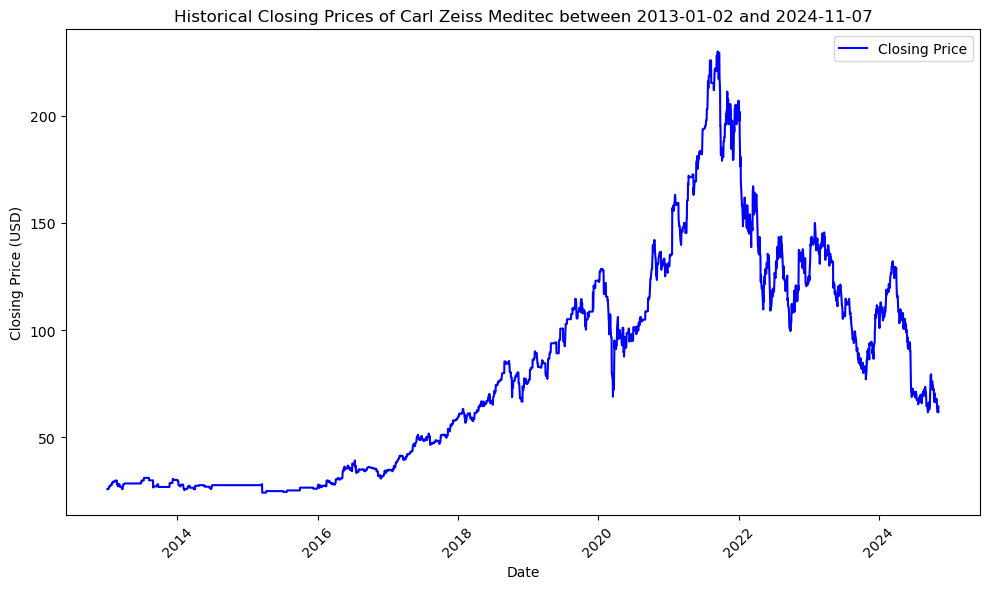


****LAM RESEARCH CORPORATION****



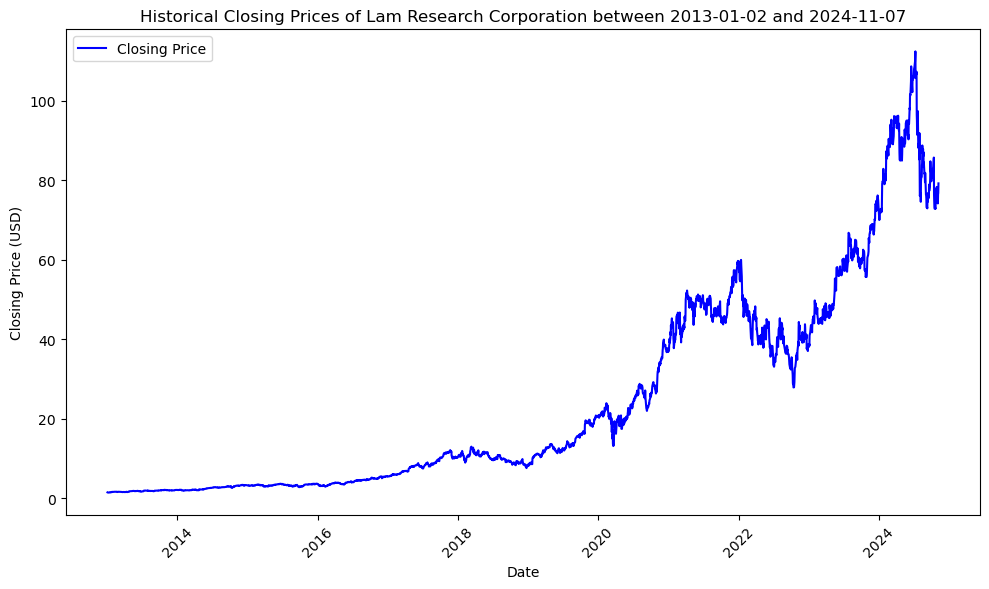


****TOKYO ELECTRON LIMITED****



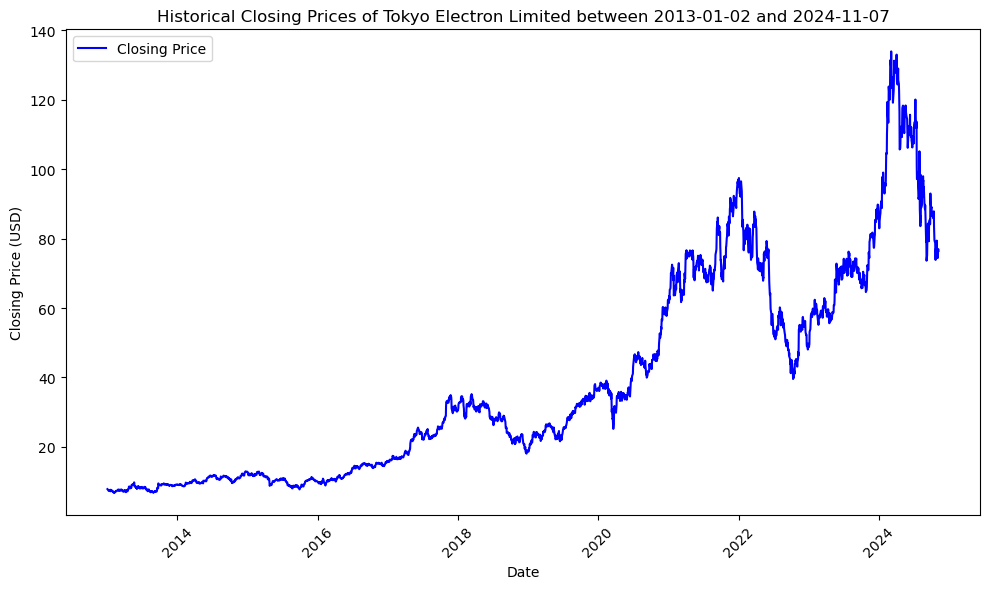

In [8]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_closing_prices(merged_data,f'Close_{company}',company)
    print()

### 2.5.2 Checking for duplicate values

In [9]:
merged_data.duplicated().sum()

0

There are no duplicated values. So we can continue

### 2.5.3 Checking for missing dates

In [10]:
(merged_data.isna().sum()/len(merged_data))*100

Close_Carl Zeiss Meditec          0.0
Close_Lam Research Corporation    0.0
Close_Tokyo Electron Limited      0.0
dtype: float64

As we can see there aren't any null values

### 2.5.4 Looking at seasonality

****CARL ZEISS MEDITEC****



<Figure size 1200x800 with 0 Axes>

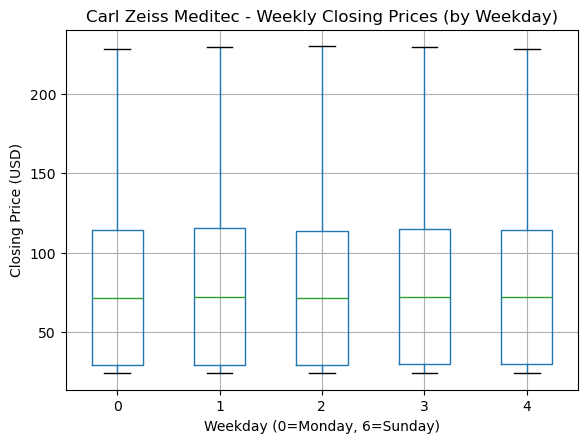

<Figure size 1200x800 with 0 Axes>

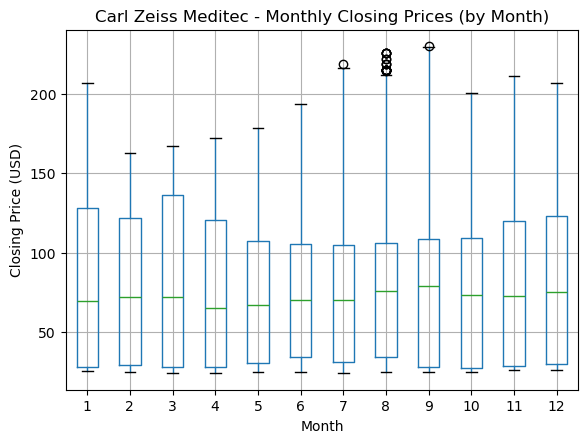

<Figure size 1200x800 with 0 Axes>

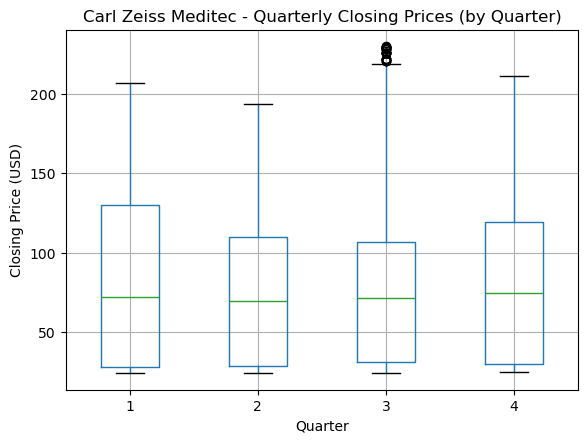


****LAM RESEARCH CORPORATION****



<Figure size 1200x800 with 0 Axes>

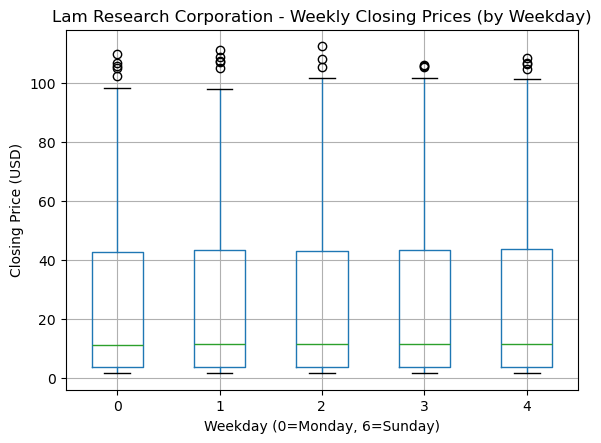

<Figure size 1200x800 with 0 Axes>

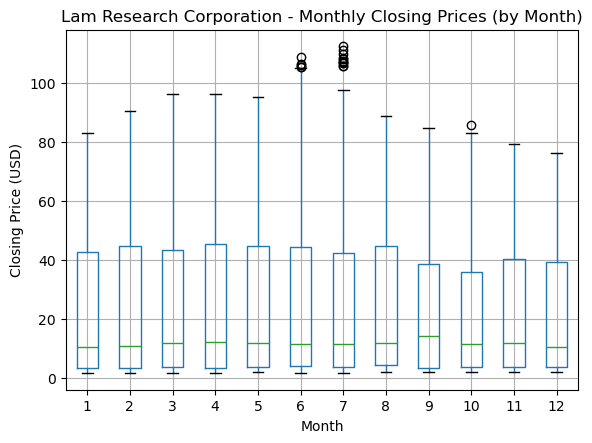

<Figure size 1200x800 with 0 Axes>

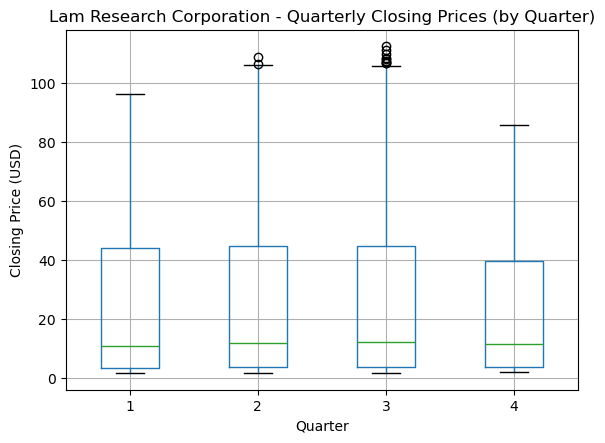


****TOKYO ELECTRON LIMITED****



<Figure size 1200x800 with 0 Axes>

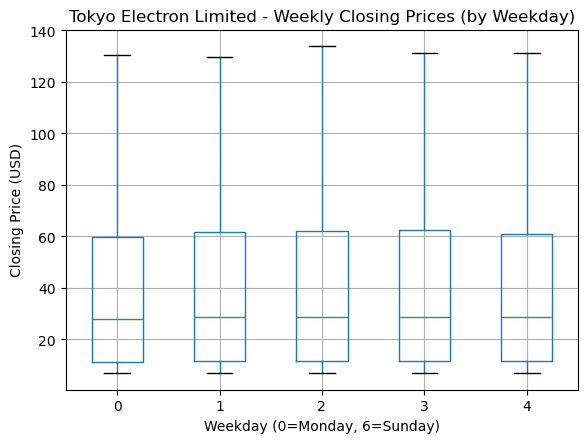

<Figure size 1200x800 with 0 Axes>

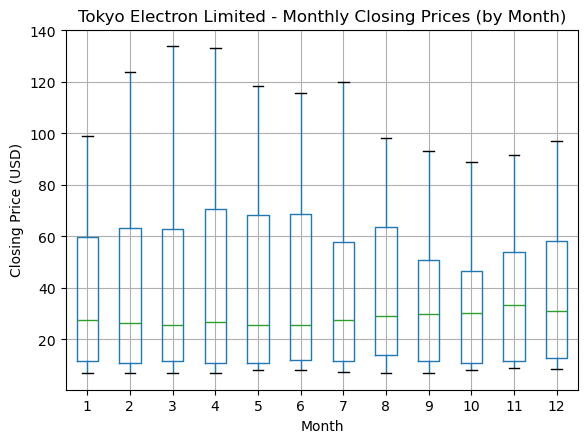

<Figure size 1200x800 with 0 Axes>

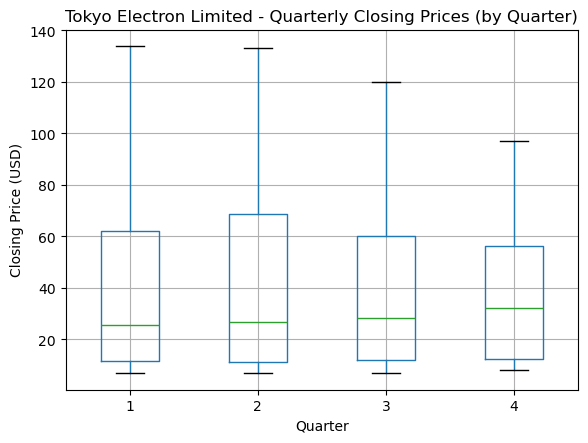

In [11]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_stock_with_multiple_boxplots(merged_data,f'Close_{company}',company)
    print()

With the results above, we cannot determine if there is any clear seasonality for any of the three suppliers. 

### 2.5.5 Choosing the time series of our dataset

Let's chose just the weekly data for the suppliers. To be consistent with the logic with which we viewed ASML's stock data

In [12]:
# Convert the index to a datetime index if it's not already
merged_data.index = pd.to_datetime(merged_data.index)

# Resample the data to weekly frequency and calculate the median
weekly_data_suppliers = merged_data.resample('W').median()

# Display the weekly data
weekly_data_suppliers.head()

,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,Date,Weekday,Month,Quarter
Date,,,,,,,
2013-01-06,25.741581,1.500429,7.766667,2013-01-03 00:00:00,3.0,1.0,1.0
2013-01-13,26.057861,1.480722,7.480000,2013-01-09 00:00:00,2.0,1.0,1.0
2013-01-20,27.226336,1.510281,7.460000,2013-01-16 00:00:00,2.0,1.0,1.0
2013-01-27,27.674395,1.580041,7.406667,2013-01-23 12:00:00,2.5,1.0,1.0
2013-02-03,28.728657,1.644283,7.140000,2013-01-30 00:00:00,2.0,1.0,1.0


### 2.5.6 Prophet model for each supplier

#### 2.5.6.1 Train-test split

In [13]:
# Drop unnecessary columns from the dataframe
weekly_data_suppliers = weekly_data_suppliers.drop(columns=['Date', 'Weekday', 'Month', 'Quarter'], axis=1)

In [14]:
# Create dictionaries to store train and test dataframes for each company
train_dataframes = {}
test_dataframes = {}

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Filter only the columns corresponding to the current company
    company_data = weekly_data_suppliers[[f'Close_{company}']]
    
    # Rename the column to 'Close'
    company_data.columns = ['Close']
    
    # Create train and test dataframes
    train_dataframes[company] = company_data[:-test_weeks]
    test_dataframes[company] = company_data[-test_weeks:]
    
    # Set 'Date' as the index of the dataframe
    train_dataframes[company].index.name = 'Date'
    test_dataframes[company].index.name = 'Date'

# Display the train dataframe for 'Carl Zeiss Meditec' as an example
train_dataframes['Carl Zeiss Meditec'].head()

,Close
Date,
2013-01-06,25.741581
2013-01-13,26.057861
2013-01-20,27.226336
2013-01-27,27.674395
2013-02-03,28.728657


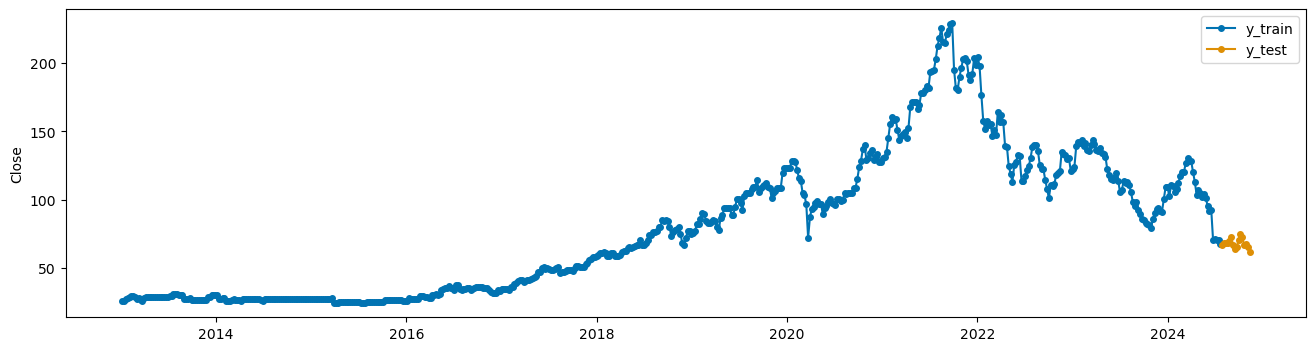

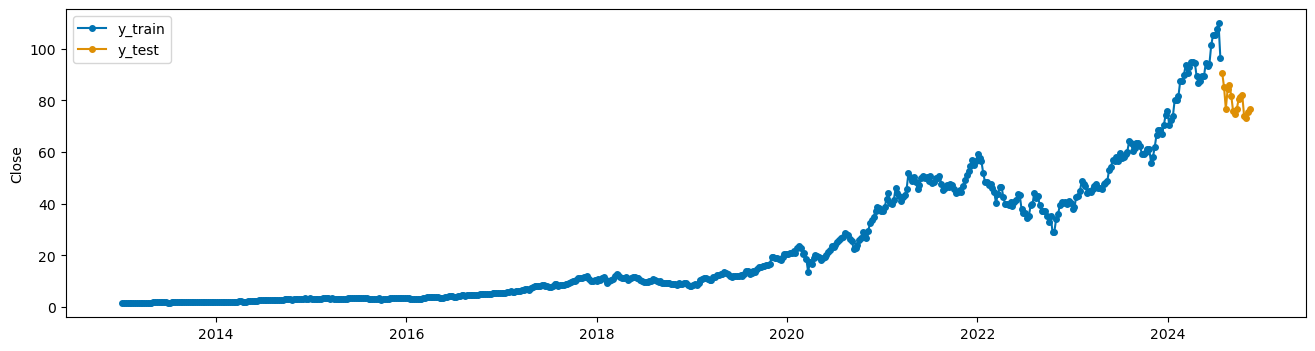

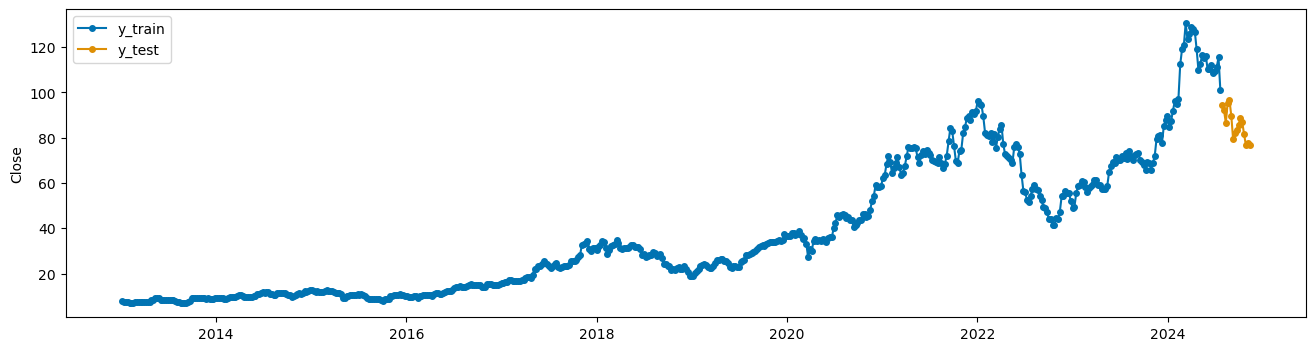

In [15]:
# Iterate over each company to plot the series
for company in company_tickers.values():
    # Extract the train and test data for the current company
    train_data = train_dataframes[company]
    test_data = test_dataframes[company]
    
    # Plot the series for the current company
    plot_series(train_data, test_data, labels=["y_train", "y_test"])

#### 2.5.6.2 Prophet models

19:32:14 - cmdstanpy - INFO - Chain [1] start processing
19:32:14 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Carl Zeiss Meditec
MAPE: 16.45
RMSE: 12.45


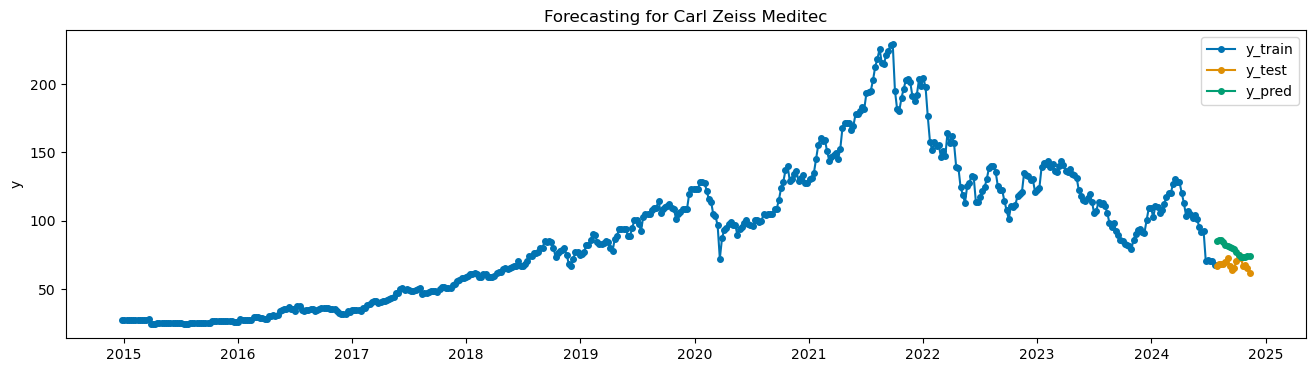

19:32:14 - cmdstanpy - INFO - Chain [1] start processing
19:32:14 - cmdstanpy - INFO - Chain [1] done processing
19:32:14 - cmdstanpy - INFO - Chain [1] start processing
19:32:14 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Lam Research Corporation
MAPE: 7.15
RMSE: 6.47


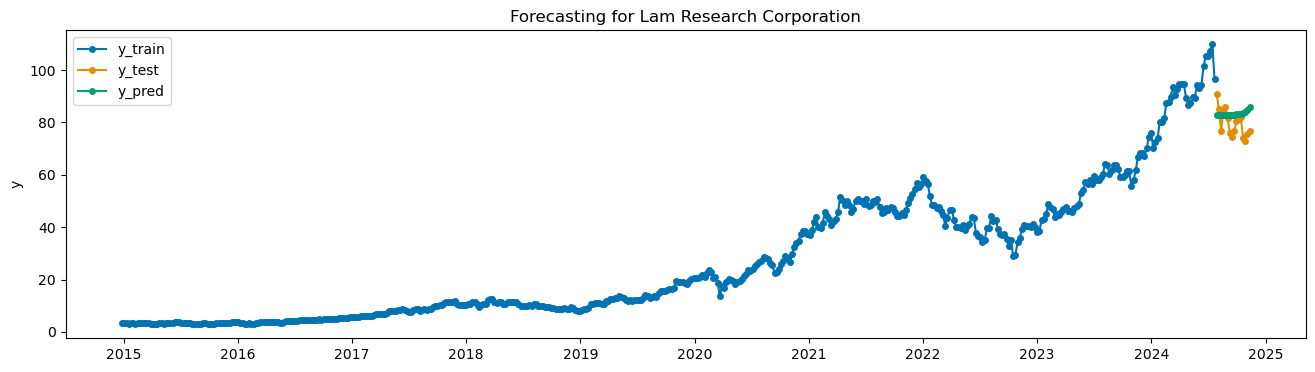

19:32:15 - cmdstanpy - INFO - Chain [1] start processing
19:32:15 - cmdstanpy - INFO - Chain [1] done processing
19:32:15 - cmdstanpy - INFO - Chain [1] start processing
19:32:15 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Tokyo Electron Limited
MAPE: 9.81
RMSE: 9.71


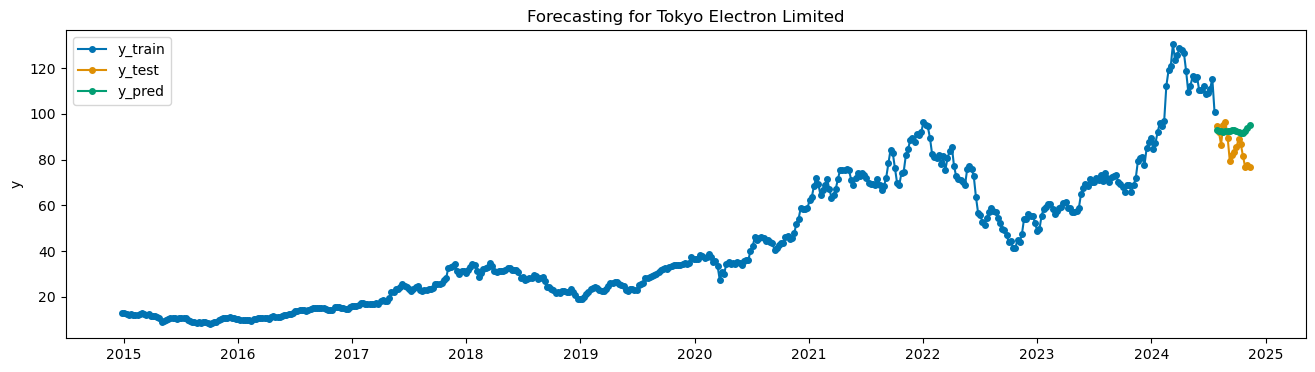

19:32:15 - cmdstanpy - INFO - Chain [1] start processing
19:32:16 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# Dictionary to store each Prophet model by company
prophet_models = {}

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Prepare the data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)  # Ensure DatetimeIndex
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    # Initialize and fit the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(train_data_prophet)

    # Define the forecast horizon (e.g., 12 periods into the future)
    future = prophet_model.make_future_dataframe(periods=test_weeks, freq='W')

    # Generate the predictions
    forecast = prophet_model.predict(future)

    # Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
    forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    # Ensure 'ds' is the index of train_data_prophet 
    train_data_prophet = train_data_prophet.set_index('ds')

    # Calculate MAPE and RMSE errors
    actuals = test_dataframes[company]['Close']  # Actual values from test data
    predictions = forecast['Close']              # Predicted values from forecast

    # Ensure the indices of actuals and predictions align
    common_index = actuals.index.intersection(predictions.index)
    actuals = actuals.loc[common_index]
    predictions = predictions.loc[common_index]

    mape = mean_absolute_percentage_error(actuals, predictions)*100
    rmse = root_mean_squared_error(actuals, predictions)

    # Display errors
    print(f'Forecasting for {company}')
    print(f'MAPE: {mape:.2f}')
    print(f'RMSE: {rmse:.2f}')
    
    # Plot the forecast results
    plot_series(
        train_data_prophet[-500:],  # Only pass the 'Close' column for training data
        test_dataframes[company],   # Only pass the 'Close' column for test data
        forecast,                   # Only pass the 'Close' column for forecast
        labels=["y_train", "y_test", "y_pred"]
    )
    
    plt.title(f'Forecasting for {company}')  # Add title for better clarity
    plt.show()  # Show the plot before moving to the next company
    
    # We need are now going to save the prophet_models only that this time, we will fit it with all the data (train and test data) 
    # Initialize the Prophet model
    prophet_model = Prophet()
    # We have modified the data to be able to train the prophet model
    test_data = pd.DataFrame(actuals).rename(columns={'Close':'y'}).reset_index(names="ds")
    train_data_prophet = train_data_prophet.reset_index(names="ds")
    all_data = pd.concat([train_data_prophet,test_data])
    prophet_model.fit(all_data)
    
    # Store the model in the dictionary with the company name as key
    prophet_models[company] = prophet_model

#### 2.5.6.3 Fine-tunning the prophet models

19:32:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 1 of 256 for Carl Zeiss Meditec...


19:32:16 - cmdstanpy - INFO - Chain [1] done processing
19:32:16 - cmdstanpy - INFO - Chain [1] start processing
19:32:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2 of 256 for Carl Zeiss Meditec...


19:32:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 3 of 256 for Carl Zeiss Meditec...


19:32:16 - cmdstanpy - INFO - Chain [1] done processing
19:32:17 - cmdstanpy - INFO - Chain [1] start processing
19:32:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 4 of 256 for Carl Zeiss Meditec...


19:32:17 - cmdstanpy - INFO - Chain [1] start processing
19:32:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 5 of 256 for Carl Zeiss Meditec...


19:32:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 6 of 256 for Carl Zeiss Meditec...


19:32:17 - cmdstanpy - INFO - Chain [1] done processing
19:32:17 - cmdstanpy - INFO - Chain [1] start processing
19:32:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 7 of 256 for Carl Zeiss Meditec...


19:32:18 - cmdstanpy - INFO - Chain [1] start processing
19:32:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 8 of 256 for Carl Zeiss Meditec...


19:32:18 - cmdstanpy - INFO - Chain [1] start processing
19:32:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 9 of 256 for Carl Zeiss Meditec...


19:32:18 - cmdstanpy - INFO - Chain [1] start processing
19:32:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 10 of 256 for Carl Zeiss Meditec...


19:32:19 - cmdstanpy - INFO - Chain [1] start processing
19:32:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 11 of 256 for Carl Zeiss Meditec...


19:32:19 - cmdstanpy - INFO - Chain [1] start processing
19:32:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 12 of 256 for Carl Zeiss Meditec...


19:32:19 - cmdstanpy - INFO - Chain [1] start processing
19:32:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 13 of 256 for Carl Zeiss Meditec...


19:32:19 - cmdstanpy - INFO - Chain [1] start processing
19:32:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 14 of 256 for Carl Zeiss Meditec...


19:32:20 - cmdstanpy - INFO - Chain [1] start processing
19:32:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 15 of 256 for Carl Zeiss Meditec...


19:32:20 - cmdstanpy - INFO - Chain [1] start processing
19:32:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 16 of 256 for Carl Zeiss Meditec...


19:32:20 - cmdstanpy - INFO - Chain [1] start processing
19:32:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 17 of 256 for Carl Zeiss Meditec...


19:32:21 - cmdstanpy - INFO - Chain [1] start processing
19:32:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 18 of 256 for Carl Zeiss Meditec...


19:32:21 - cmdstanpy - INFO - Chain [1] start processing
19:32:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 19 of 256 for Carl Zeiss Meditec...


19:32:21 - cmdstanpy - INFO - Chain [1] start processing
19:32:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 20 of 256 for Carl Zeiss Meditec...


19:32:21 - cmdstanpy - INFO - Chain [1] start processing
19:32:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 21 of 256 for Carl Zeiss Meditec...


19:32:22 - cmdstanpy - INFO - Chain [1] start processing
19:32:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 22 of 256 for Carl Zeiss Meditec...


19:32:22 - cmdstanpy - INFO - Chain [1] start processing
19:32:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 23 of 256 for Carl Zeiss Meditec...


19:32:22 - cmdstanpy - INFO - Chain [1] start processing
19:32:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 24 of 256 for Carl Zeiss Meditec...


19:32:23 - cmdstanpy - INFO - Chain [1] start processing
19:32:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 25 of 256 for Carl Zeiss Meditec...


19:32:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 26 of 256 for Carl Zeiss Meditec...


19:32:23 - cmdstanpy - INFO - Chain [1] done processing
19:32:23 - cmdstanpy - INFO - Chain [1] start processing
19:32:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 27 of 256 for Carl Zeiss Meditec...


19:32:24 - cmdstanpy - INFO - Chain [1] start processing
19:32:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 28 of 256 for Carl Zeiss Meditec...


19:32:24 - cmdstanpy - INFO - Chain [1] start processing
19:32:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 29 of 256 for Carl Zeiss Meditec...


19:32:24 - cmdstanpy - INFO - Chain [1] start processing
19:32:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 30 of 256 for Carl Zeiss Meditec...


19:32:24 - cmdstanpy - INFO - Chain [1] start processing
19:32:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 31 of 256 for Carl Zeiss Meditec...


19:32:25 - cmdstanpy - INFO - Chain [1] start processing
19:32:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 32 of 256 for Carl Zeiss Meditec...


19:32:25 - cmdstanpy - INFO - Chain [1] start processing
19:32:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 33 of 256 for Carl Zeiss Meditec...


19:32:25 - cmdstanpy - INFO - Chain [1] start processing
19:32:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 34 of 256 for Carl Zeiss Meditec...


19:32:25 - cmdstanpy - INFO - Chain [1] start processing
19:32:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 35 of 256 for Carl Zeiss Meditec...


19:32:26 - cmdstanpy - INFO - Chain [1] start processing
19:32:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 36 of 256 for Carl Zeiss Meditec...


19:32:26 - cmdstanpy - INFO - Chain [1] start processing
19:32:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 37 of 256 for Carl Zeiss Meditec...


19:32:26 - cmdstanpy - INFO - Chain [1] start processing
19:32:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 38 of 256 for Carl Zeiss Meditec...


19:32:26 - cmdstanpy - INFO - Chain [1] start processing
19:32:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 39 of 256 for Carl Zeiss Meditec...


19:32:27 - cmdstanpy - INFO - Chain [1] start processing
19:32:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 40 of 256 for Carl Zeiss Meditec...
Processing combination 41 of 256 for Carl Zeiss Meditec...


19:32:27 - cmdstanpy - INFO - Chain [1] start processing
19:32:27 - cmdstanpy - INFO - Chain [1] done processing
19:32:27 - cmdstanpy - INFO - Chain [1] start processing
19:32:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 42 of 256 for Carl Zeiss Meditec...


19:32:28 - cmdstanpy - INFO - Chain [1] start processing
19:32:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 43 of 256 for Carl Zeiss Meditec...


19:32:28 - cmdstanpy - INFO - Chain [1] start processing
19:32:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 44 of 256 for Carl Zeiss Meditec...


19:32:28 - cmdstanpy - INFO - Chain [1] start processing
19:32:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 45 of 256 for Carl Zeiss Meditec...


19:32:28 - cmdstanpy - INFO - Chain [1] start processing
19:32:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 46 of 256 for Carl Zeiss Meditec...


19:32:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 47 of 256 for Carl Zeiss Meditec...


19:32:29 - cmdstanpy - INFO - Chain [1] done processing
19:32:29 - cmdstanpy - INFO - Chain [1] start processing
19:32:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 48 of 256 for Carl Zeiss Meditec...


19:32:29 - cmdstanpy - INFO - Chain [1] start processing
19:32:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 49 of 256 for Carl Zeiss Meditec...


19:32:29 - cmdstanpy - INFO - Chain [1] start processing
19:32:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 50 of 256 for Carl Zeiss Meditec...


19:32:30 - cmdstanpy - INFO - Chain [1] start processing
19:32:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 51 of 256 for Carl Zeiss Meditec...


19:32:30 - cmdstanpy - INFO - Chain [1] start processing
19:32:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 52 of 256 for Carl Zeiss Meditec...
Processing combination 53 of 256 for Carl Zeiss Meditec...


19:32:30 - cmdstanpy - INFO - Chain [1] start processing
19:32:30 - cmdstanpy - INFO - Chain [1] done processing
19:32:30 - cmdstanpy - INFO - Chain [1] start processing
19:32:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 54 of 256 for Carl Zeiss Meditec...


19:32:31 - cmdstanpy - INFO - Chain [1] start processing
19:32:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 55 of 256 for Carl Zeiss Meditec...


19:32:31 - cmdstanpy - INFO - Chain [1] start processing
19:32:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 56 of 256 for Carl Zeiss Meditec...


19:32:31 - cmdstanpy - INFO - Chain [1] start processing
19:32:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 57 of 256 for Carl Zeiss Meditec...


19:32:31 - cmdstanpy - INFO - Chain [1] start processing
19:32:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 58 of 256 for Carl Zeiss Meditec...


19:32:32 - cmdstanpy - INFO - Chain [1] start processing
19:32:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 59 of 256 for Carl Zeiss Meditec...


19:32:32 - cmdstanpy - INFO - Chain [1] start processing
19:32:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 60 of 256 for Carl Zeiss Meditec...


19:32:32 - cmdstanpy - INFO - Chain [1] start processing
19:32:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 61 of 256 for Carl Zeiss Meditec...


19:32:32 - cmdstanpy - INFO - Chain [1] start processing
19:32:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 62 of 256 for Carl Zeiss Meditec...


19:32:33 - cmdstanpy - INFO - Chain [1] start processing
19:32:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 63 of 256 for Carl Zeiss Meditec...


19:32:33 - cmdstanpy - INFO - Chain [1] start processing
19:32:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 64 of 256 for Carl Zeiss Meditec...


19:32:33 - cmdstanpy - INFO - Chain [1] start processing
19:32:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 65 of 256 for Carl Zeiss Meditec...


19:32:33 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 66 of 256 for Carl Zeiss Meditec...


19:32:34 - cmdstanpy - INFO - Chain [1] done processing
19:32:34 - cmdstanpy - INFO - Chain [1] start processing
19:32:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 67 of 256 for Carl Zeiss Meditec...


19:32:34 - cmdstanpy - INFO - Chain [1] start processing
19:32:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 68 of 256 for Carl Zeiss Meditec...


19:32:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 69 of 256 for Carl Zeiss Meditec...


19:32:34 - cmdstanpy - INFO - Chain [1] done processing
19:32:35 - cmdstanpy - INFO - Chain [1] start processing
19:32:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 70 of 256 for Carl Zeiss Meditec...


19:32:35 - cmdstanpy - INFO - Chain [1] start processing
19:32:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 71 of 256 for Carl Zeiss Meditec...


19:32:35 - cmdstanpy - INFO - Chain [1] start processing
19:32:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 72 of 256 for Carl Zeiss Meditec...


19:32:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 73 of 256 for Carl Zeiss Meditec...


19:32:36 - cmdstanpy - INFO - Chain [1] done processing
19:32:36 - cmdstanpy - INFO - Chain [1] start processing
19:32:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 74 of 256 for Carl Zeiss Meditec...


19:32:36 - cmdstanpy - INFO - Chain [1] start processing
19:32:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 75 of 256 for Carl Zeiss Meditec...


19:32:36 - cmdstanpy - INFO - Chain [1] start processing
19:32:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 76 of 256 for Carl Zeiss Meditec...


19:32:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 77 of 256 for Carl Zeiss Meditec...


19:32:37 - cmdstanpy - INFO - Chain [1] done processing
19:32:37 - cmdstanpy - INFO - Chain [1] start processing
19:32:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 78 of 256 for Carl Zeiss Meditec...


19:32:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 79 of 256 for Carl Zeiss Meditec...


19:32:37 - cmdstanpy - INFO - Chain [1] done processing
19:32:37 - cmdstanpy - INFO - Chain [1] start processing
19:32:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 80 of 256 for Carl Zeiss Meditec...


19:32:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 81 of 256 for Carl Zeiss Meditec...


19:32:38 - cmdstanpy - INFO - Chain [1] done processing
19:32:38 - cmdstanpy - INFO - Chain [1] start processing
19:32:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 82 of 256 for Carl Zeiss Meditec...


19:32:38 - cmdstanpy - INFO - Chain [1] start processing
19:32:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 83 of 256 for Carl Zeiss Meditec...


19:32:39 - cmdstanpy - INFO - Chain [1] start processing
19:32:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 84 of 256 for Carl Zeiss Meditec...


19:32:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 85 of 256 for Carl Zeiss Meditec...


19:32:39 - cmdstanpy - INFO - Chain [1] done processing
19:32:39 - cmdstanpy - INFO - Chain [1] start processing
19:32:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 86 of 256 for Carl Zeiss Meditec...


19:32:40 - cmdstanpy - INFO - Chain [1] start processing
19:32:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 87 of 256 for Carl Zeiss Meditec...


19:32:40 - cmdstanpy - INFO - Chain [1] start processing
19:32:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 88 of 256 for Carl Zeiss Meditec...


19:32:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 89 of 256 for Carl Zeiss Meditec...


19:32:40 - cmdstanpy - INFO - Chain [1] done processing
19:32:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 90 of 256 for Carl Zeiss Meditec...


19:32:40 - cmdstanpy - INFO - Chain [1] done processing
19:32:41 - cmdstanpy - INFO - Chain [1] start processing
19:32:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 91 of 256 for Carl Zeiss Meditec...


19:32:41 - cmdstanpy - INFO - Chain [1] start processing
19:32:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 92 of 256 for Carl Zeiss Meditec...


19:32:41 - cmdstanpy - INFO - Chain [1] start processing
19:32:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 93 of 256 for Carl Zeiss Meditec...


19:32:41 - cmdstanpy - INFO - Chain [1] start processing
19:32:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 94 of 256 for Carl Zeiss Meditec...


19:32:42 - cmdstanpy - INFO - Chain [1] start processing
19:32:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 95 of 256 for Carl Zeiss Meditec...


19:32:42 - cmdstanpy - INFO - Chain [1] start processing
19:32:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 96 of 256 for Carl Zeiss Meditec...


19:32:42 - cmdstanpy - INFO - Chain [1] start processing
19:32:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 97 of 256 for Carl Zeiss Meditec...


19:32:43 - cmdstanpy - INFO - Chain [1] start processing
19:32:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 98 of 256 for Carl Zeiss Meditec...


19:32:43 - cmdstanpy - INFO - Chain [1] start processing
19:32:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 99 of 256 for Carl Zeiss Meditec...


19:32:43 - cmdstanpy - INFO - Chain [1] start processing
19:32:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 100 of 256 for Carl Zeiss Meditec...


19:32:43 - cmdstanpy - INFO - Chain [1] start processing
19:32:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 101 of 256 for Carl Zeiss Meditec...


19:32:44 - cmdstanpy - INFO - Chain [1] start processing
19:32:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 102 of 256 for Carl Zeiss Meditec...


19:32:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 103 of 256 for Carl Zeiss Meditec...


19:32:44 - cmdstanpy - INFO - Chain [1] done processing
19:32:44 - cmdstanpy - INFO - Chain [1] start processing
19:32:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 104 of 256 for Carl Zeiss Meditec...


19:32:44 - cmdstanpy - INFO - Chain [1] start processing
19:32:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 105 of 256 for Carl Zeiss Meditec...


19:32:45 - cmdstanpy - INFO - Chain [1] start processing
19:32:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 106 of 256 for Carl Zeiss Meditec...


19:32:45 - cmdstanpy - INFO - Chain [1] start processing
19:32:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 107 of 256 for Carl Zeiss Meditec...


19:32:45 - cmdstanpy - INFO - Chain [1] start processing
19:32:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 108 of 256 for Carl Zeiss Meditec...


19:32:45 - cmdstanpy - INFO - Chain [1] start processing
19:32:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 109 of 256 for Carl Zeiss Meditec...


19:32:46 - cmdstanpy - INFO - Chain [1] start processing
19:32:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 110 of 256 for Carl Zeiss Meditec...


19:32:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 111 of 256 for Carl Zeiss Meditec...


19:32:46 - cmdstanpy - INFO - Chain [1] done processing
19:32:46 - cmdstanpy - INFO - Chain [1] start processing
19:32:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 112 of 256 for Carl Zeiss Meditec...


19:32:47 - cmdstanpy - INFO - Chain [1] start processing
19:32:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 113 of 256 for Carl Zeiss Meditec...


19:32:47 - cmdstanpy - INFO - Chain [1] start processing
19:32:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 114 of 256 for Carl Zeiss Meditec...


19:32:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 115 of 256 for Carl Zeiss Meditec...


19:32:47 - cmdstanpy - INFO - Chain [1] done processing
19:32:47 - cmdstanpy - INFO - Chain [1] start processing
19:32:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 116 of 256 for Carl Zeiss Meditec...


19:32:48 - cmdstanpy - INFO - Chain [1] start processing
19:32:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 117 of 256 for Carl Zeiss Meditec...


19:32:48 - cmdstanpy - INFO - Chain [1] start processing
19:32:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 118 of 256 for Carl Zeiss Meditec...


19:32:48 - cmdstanpy - INFO - Chain [1] start processing
19:32:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 119 of 256 for Carl Zeiss Meditec...


19:32:48 - cmdstanpy - INFO - Chain [1] start processing
19:32:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 120 of 256 for Carl Zeiss Meditec...


19:32:49 - cmdstanpy - INFO - Chain [1] start processing
19:32:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 121 of 256 for Carl Zeiss Meditec...


19:32:49 - cmdstanpy - INFO - Chain [1] start processing
19:32:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 122 of 256 for Carl Zeiss Meditec...


19:32:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 123 of 256 for Carl Zeiss Meditec...


19:32:49 - cmdstanpy - INFO - Chain [1] done processing
19:32:49 - cmdstanpy - INFO - Chain [1] start processing
19:32:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 124 of 256 for Carl Zeiss Meditec...


19:32:50 - cmdstanpy - INFO - Chain [1] start processing
19:32:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 125 of 256 for Carl Zeiss Meditec...


19:32:50 - cmdstanpy - INFO - Chain [1] start processing
19:32:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 126 of 256 for Carl Zeiss Meditec...


19:32:50 - cmdstanpy - INFO - Chain [1] start processing
19:32:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 127 of 256 for Carl Zeiss Meditec...


19:32:51 - cmdstanpy - INFO - Chain [1] start processing
19:32:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 128 of 256 for Carl Zeiss Meditec...


19:32:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 129 of 256 for Carl Zeiss Meditec...


19:32:51 - cmdstanpy - INFO - Chain [1] done processing
19:32:51 - cmdstanpy - INFO - Chain [1] start processing
19:32:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 130 of 256 for Carl Zeiss Meditec...


19:32:51 - cmdstanpy - INFO - Chain [1] start processing
19:32:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 131 of 256 for Carl Zeiss Meditec...


19:32:52 - cmdstanpy - INFO - Chain [1] start processing
19:32:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 132 of 256 for Carl Zeiss Meditec...


19:32:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 133 of 256 for Carl Zeiss Meditec...


19:32:52 - cmdstanpy - INFO - Chain [1] done processing
19:32:52 - cmdstanpy - INFO - Chain [1] start processing
19:32:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 134 of 256 for Carl Zeiss Meditec...


19:32:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 135 of 256 for Carl Zeiss Meditec...


19:32:53 - cmdstanpy - INFO - Chain [1] done processing
19:32:53 - cmdstanpy - INFO - Chain [1] start processing
19:32:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 136 of 256 for Carl Zeiss Meditec...


19:32:53 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 137 of 256 for Carl Zeiss Meditec...


19:32:53 - cmdstanpy - INFO - Chain [1] done processing
19:32:54 - cmdstanpy - INFO - Chain [1] start processing
19:32:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 138 of 256 for Carl Zeiss Meditec...


19:32:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 139 of 256 for Carl Zeiss Meditec...


19:32:54 - cmdstanpy - INFO - Chain [1] done processing
19:32:54 - cmdstanpy - INFO - Chain [1] start processing
19:32:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 140 of 256 for Carl Zeiss Meditec...


19:32:54 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 141 of 256 for Carl Zeiss Meditec...


19:32:55 - cmdstanpy - INFO - Chain [1] done processing
19:32:55 - cmdstanpy - INFO - Chain [1] start processing
19:32:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 142 of 256 for Carl Zeiss Meditec...


19:32:55 - cmdstanpy - INFO - Chain [1] start processing
19:32:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 143 of 256 for Carl Zeiss Meditec...


19:32:55 - cmdstanpy - INFO - Chain [1] start processing
19:32:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 144 of 256 for Carl Zeiss Meditec...


19:32:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 145 of 256 for Carl Zeiss Meditec...


19:32:56 - cmdstanpy - INFO - Chain [1] done processing
19:32:56 - cmdstanpy - INFO - Chain [1] start processing
19:32:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 146 of 256 for Carl Zeiss Meditec...


19:32:56 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 147 of 256 for Carl Zeiss Meditec...


19:32:56 - cmdstanpy - INFO - Chain [1] done processing
19:32:56 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 148 of 256 for Carl Zeiss Meditec...


19:32:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 149 of 256 for Carl Zeiss Meditec...


19:32:57 - cmdstanpy - INFO - Chain [1] done processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 150 of 256 for Carl Zeiss Meditec...


19:32:57 - cmdstanpy - INFO - Chain [1] done processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 151 of 256 for Carl Zeiss Meditec...


19:32:58 - cmdstanpy - INFO - Chain [1] start processing
19:32:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 152 of 256 for Carl Zeiss Meditec...


19:32:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 153 of 256 for Carl Zeiss Meditec...


19:32:58 - cmdstanpy - INFO - Chain [1] done processing
19:32:58 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 154 of 256 for Carl Zeiss Meditec...


19:32:58 - cmdstanpy - INFO - Chain [1] done processing
19:32:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 155 of 256 for Carl Zeiss Meditec...


19:32:59 - cmdstanpy - INFO - Chain [1] done processing
19:32:59 - cmdstanpy - INFO - Chain [1] start processing
19:32:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 156 of 256 for Carl Zeiss Meditec...


19:32:59 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 157 of 256 for Carl Zeiss Meditec...


19:33:00 - cmdstanpy - INFO - Chain [1] done processing
19:33:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 158 of 256 for Carl Zeiss Meditec...


19:33:00 - cmdstanpy - INFO - Chain [1] done processing
19:33:00 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 159 of 256 for Carl Zeiss Meditec...


19:33:00 - cmdstanpy - INFO - Chain [1] done processing
19:33:00 - cmdstanpy - INFO - Chain [1] start processing
19:33:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 160 of 256 for Carl Zeiss Meditec...


19:33:01 - cmdstanpy - INFO - Chain [1] start processing
19:33:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 161 of 256 for Carl Zeiss Meditec...


19:33:01 - cmdstanpy - INFO - Chain [1] start processing
19:33:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 162 of 256 for Carl Zeiss Meditec...


19:33:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 163 of 256 for Carl Zeiss Meditec...


19:33:01 - cmdstanpy - INFO - Chain [1] done processing
19:33:01 - cmdstanpy - INFO - Chain [1] start processing
19:33:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 164 of 256 for Carl Zeiss Meditec...


19:33:02 - cmdstanpy - INFO - Chain [1] start processing
19:33:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 165 of 256 for Carl Zeiss Meditec...


19:33:02 - cmdstanpy - INFO - Chain [1] start processing
19:33:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 166 of 256 for Carl Zeiss Meditec...


19:33:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 167 of 256 for Carl Zeiss Meditec...


19:33:02 - cmdstanpy - INFO - Chain [1] done processing
19:33:03 - cmdstanpy - INFO - Chain [1] start processing
19:33:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 168 of 256 for Carl Zeiss Meditec...


19:33:03 - cmdstanpy - INFO - Chain [1] start processing
19:33:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 169 of 256 for Carl Zeiss Meditec...


19:33:03 - cmdstanpy - INFO - Chain [1] start processing
19:33:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 170 of 256 for Carl Zeiss Meditec...


19:33:03 - cmdstanpy - INFO - Chain [1] start processing
19:33:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 171 of 256 for Carl Zeiss Meditec...


19:33:04 - cmdstanpy - INFO - Chain [1] start processing
19:33:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 172 of 256 for Carl Zeiss Meditec...


19:33:04 - cmdstanpy - INFO - Chain [1] start processing
19:33:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 173 of 256 for Carl Zeiss Meditec...


19:33:04 - cmdstanpy - INFO - Chain [1] start processing
19:33:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 174 of 256 for Carl Zeiss Meditec...


19:33:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 175 of 256 for Carl Zeiss Meditec...


19:33:05 - cmdstanpy - INFO - Chain [1] done processing
19:33:05 - cmdstanpy - INFO - Chain [1] start processing
19:33:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 176 of 256 for Carl Zeiss Meditec...


19:33:05 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 177 of 256 for Carl Zeiss Meditec...


19:33:05 - cmdstanpy - INFO - Chain [1] done processing
19:33:05 - cmdstanpy - INFO - Chain [1] start processing
19:33:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 178 of 256 for Carl Zeiss Meditec...


19:33:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 179 of 256 for Carl Zeiss Meditec...


19:33:06 - cmdstanpy - INFO - Chain [1] done processing
19:33:06 - cmdstanpy - INFO - Chain [1] start processing
19:33:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 180 of 256 for Carl Zeiss Meditec...


19:33:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 181 of 256 for Carl Zeiss Meditec...


19:33:06 - cmdstanpy - INFO - Chain [1] done processing
19:33:06 - cmdstanpy - INFO - Chain [1] start processing
19:33:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 182 of 256 for Carl Zeiss Meditec...


19:33:07 - cmdstanpy - INFO - Chain [1] start processing
19:33:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 183 of 256 for Carl Zeiss Meditec...


19:33:07 - cmdstanpy - INFO - Chain [1] start processing
19:33:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 184 of 256 for Carl Zeiss Meditec...


19:33:07 - cmdstanpy - INFO - Chain [1] start processing
19:33:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 185 of 256 for Carl Zeiss Meditec...


19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 186 of 256 for Carl Zeiss Meditec...


19:33:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 187 of 256 for Carl Zeiss Meditec...


19:33:08 - cmdstanpy - INFO - Chain [1] done processing
19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 188 of 256 for Carl Zeiss Meditec...


19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 189 of 256 for Carl Zeiss Meditec...


19:33:09 - cmdstanpy - INFO - Chain [1] start processing
19:33:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 190 of 256 for Carl Zeiss Meditec...


19:33:09 - cmdstanpy - INFO - Chain [1] start processing
19:33:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 191 of 256 for Carl Zeiss Meditec...


19:33:09 - cmdstanpy - INFO - Chain [1] start processing
19:33:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 192 of 256 for Carl Zeiss Meditec...


19:33:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 193 of 256 for Carl Zeiss Meditec...


19:33:10 - cmdstanpy - INFO - Chain [1] done processing
19:33:10 - cmdstanpy - INFO - Chain [1] start processing
19:33:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 194 of 256 for Carl Zeiss Meditec...


19:33:10 - cmdstanpy - INFO - Chain [1] start processing
19:33:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 195 of 256 for Carl Zeiss Meditec...


19:33:10 - cmdstanpy - INFO - Chain [1] start processing
19:33:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 196 of 256 for Carl Zeiss Meditec...


19:33:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 197 of 256 for Carl Zeiss Meditec...


19:33:11 - cmdstanpy - INFO - Chain [1] done processing
19:33:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 198 of 256 for Carl Zeiss Meditec...


19:33:11 - cmdstanpy - INFO - Chain [1] done processing
19:33:11 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 199 of 256 for Carl Zeiss Meditec...


19:33:11 - cmdstanpy - INFO - Chain [1] done processing
19:33:11 - cmdstanpy - INFO - Chain [1] start processing
19:33:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 200 of 256 for Carl Zeiss Meditec...


19:33:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 201 of 256 for Carl Zeiss Meditec...


19:33:12 - cmdstanpy - INFO - Chain [1] done processing
19:33:12 - cmdstanpy - INFO - Chain [1] start processing
19:33:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 202 of 256 for Carl Zeiss Meditec...


19:33:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 203 of 256 for Carl Zeiss Meditec...


19:33:13 - cmdstanpy - INFO - Chain [1] done processing
19:33:13 - cmdstanpy - INFO - Chain [1] start processing
19:33:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 204 of 256 for Carl Zeiss Meditec...


19:33:13 - cmdstanpy - INFO - Chain [1] start processing
19:33:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 205 of 256 for Carl Zeiss Meditec...


19:33:13 - cmdstanpy - INFO - Chain [1] start processing
19:33:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 206 of 256 for Carl Zeiss Meditec...


19:33:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 207 of 256 for Carl Zeiss Meditec...


19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 208 of 256 for Carl Zeiss Meditec...


19:33:14 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 209 of 256 for Carl Zeiss Meditec...


19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 210 of 256 for Carl Zeiss Meditec...


19:33:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 211 of 256 for Carl Zeiss Meditec...


19:33:15 - cmdstanpy - INFO - Chain [1] done processing
19:33:15 - cmdstanpy - INFO - Chain [1] start processing
19:33:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 212 of 256 for Carl Zeiss Meditec...


19:33:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 213 of 256 for Carl Zeiss Meditec...


19:33:15 - cmdstanpy - INFO - Chain [1] done processing
19:33:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 214 of 256 for Carl Zeiss Meditec...


19:33:16 - cmdstanpy - INFO - Chain [1] done processing
19:33:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 215 of 256 for Carl Zeiss Meditec...


19:33:16 - cmdstanpy - INFO - Chain [1] done processing
19:33:16 - cmdstanpy - INFO - Chain [1] start processing
19:33:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 216 of 256 for Carl Zeiss Meditec...


19:33:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 217 of 256 for Carl Zeiss Meditec...


19:33:17 - cmdstanpy - INFO - Chain [1] done processing
19:33:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 218 of 256 for Carl Zeiss Meditec...


19:33:17 - cmdstanpy - INFO - Chain [1] done processing
19:33:17 - cmdstanpy - INFO - Chain [1] start processing
19:33:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 219 of 256 for Carl Zeiss Meditec...


19:33:18 - cmdstanpy - INFO - Chain [1] start processing
19:33:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 220 of 256 for Carl Zeiss Meditec...


19:33:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 221 of 256 for Carl Zeiss Meditec...


19:33:18 - cmdstanpy - INFO - Chain [1] done processing
19:33:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 222 of 256 for Carl Zeiss Meditec...


19:33:18 - cmdstanpy - INFO - Chain [1] done processing
19:33:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 223 of 256 for Carl Zeiss Meditec...


19:33:19 - cmdstanpy - INFO - Chain [1] done processing
19:33:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 224 of 256 for Carl Zeiss Meditec...


19:33:19 - cmdstanpy - INFO - Chain [1] done processing
19:33:19 - cmdstanpy - INFO - Chain [1] start processing
19:33:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 225 of 256 for Carl Zeiss Meditec...


19:33:20 - cmdstanpy - INFO - Chain [1] start processing
19:33:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 226 of 256 for Carl Zeiss Meditec...


19:33:20 - cmdstanpy - INFO - Chain [1] start processing
19:33:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 227 of 256 for Carl Zeiss Meditec...


19:33:20 - cmdstanpy - INFO - Chain [1] start processing
19:33:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 228 of 256 for Carl Zeiss Meditec...


19:33:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 229 of 256 for Carl Zeiss Meditec...


19:33:21 - cmdstanpy - INFO - Chain [1] done processing
19:33:21 - cmdstanpy - INFO - Chain [1] start processing
19:33:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 230 of 256 for Carl Zeiss Meditec...


19:33:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 231 of 256 for Carl Zeiss Meditec...


19:33:21 - cmdstanpy - INFO - Chain [1] done processing
19:33:21 - cmdstanpy - INFO - Chain [1] start processing
19:33:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 232 of 256 for Carl Zeiss Meditec...


19:33:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 233 of 256 for Carl Zeiss Meditec...


19:33:22 - cmdstanpy - INFO - Chain [1] done processing
19:33:22 - cmdstanpy - INFO - Chain [1] start processing
19:33:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 234 of 256 for Carl Zeiss Meditec...


19:33:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 235 of 256 for Carl Zeiss Meditec...


19:33:22 - cmdstanpy - INFO - Chain [1] done processing
19:33:23 - cmdstanpy - INFO - Chain [1] start processing
19:33:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 236 of 256 for Carl Zeiss Meditec...


19:33:23 - cmdstanpy - INFO - Chain [1] start processing
19:33:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 237 of 256 for Carl Zeiss Meditec...


19:33:23 - cmdstanpy - INFO - Chain [1] start processing
19:33:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 238 of 256 for Carl Zeiss Meditec...


19:33:23 - cmdstanpy - INFO - Chain [1] start processing
19:33:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 239 of 256 for Carl Zeiss Meditec...


19:33:24 - cmdstanpy - INFO - Chain [1] start processing
19:33:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 240 of 256 for Carl Zeiss Meditec...
Processing combination 241 of 256 for Carl Zeiss Meditec...


19:33:24 - cmdstanpy - INFO - Chain [1] start processing
19:33:24 - cmdstanpy - INFO - Chain [1] done processing
19:33:24 - cmdstanpy - INFO - Chain [1] start processing
19:33:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 242 of 256 for Carl Zeiss Meditec...


19:33:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 243 of 256 for Carl Zeiss Meditec...


19:33:25 - cmdstanpy - INFO - Chain [1] done processing
19:33:25 - cmdstanpy - INFO - Chain [1] start processing
19:33:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 244 of 256 for Carl Zeiss Meditec...


19:33:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 245 of 256 for Carl Zeiss Meditec...


19:33:25 - cmdstanpy - INFO - Chain [1] done processing
19:33:25 - cmdstanpy - INFO - Chain [1] start processing
19:33:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 246 of 256 for Carl Zeiss Meditec...


19:33:25 - cmdstanpy - INFO - Chain [1] start processing
19:33:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 247 of 256 for Carl Zeiss Meditec...


19:33:26 - cmdstanpy - INFO - Chain [1] start processing
19:33:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 248 of 256 for Carl Zeiss Meditec...


19:33:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 249 of 256 for Carl Zeiss Meditec...


19:33:26 - cmdstanpy - INFO - Chain [1] done processing
19:33:26 - cmdstanpy - INFO - Chain [1] start processing
19:33:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 250 of 256 for Carl Zeiss Meditec...


19:33:27 - cmdstanpy - INFO - Chain [1] start processing
19:33:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 251 of 256 for Carl Zeiss Meditec...


19:33:27 - cmdstanpy - INFO - Chain [1] start processing
19:33:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 252 of 256 for Carl Zeiss Meditec...


19:33:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 253 of 256 for Carl Zeiss Meditec...


19:33:27 - cmdstanpy - INFO - Chain [1] done processing
19:33:27 - cmdstanpy - INFO - Chain [1] start processing
19:33:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 254 of 256 for Carl Zeiss Meditec...


19:33:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 255 of 256 for Carl Zeiss Meditec...


19:33:28 - cmdstanpy - INFO - Chain [1] done processing
19:33:28 - cmdstanpy - INFO - Chain [1] start processing
19:33:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 256 of 256 for Carl Zeiss Meditec...
Best parameters for Carl Zeiss Meditec: {'changepoint_prior_scale': 0.05, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.03, 'weekly_seasonality': True, 'yearly_seasonality': False} with MAPE: 11.67


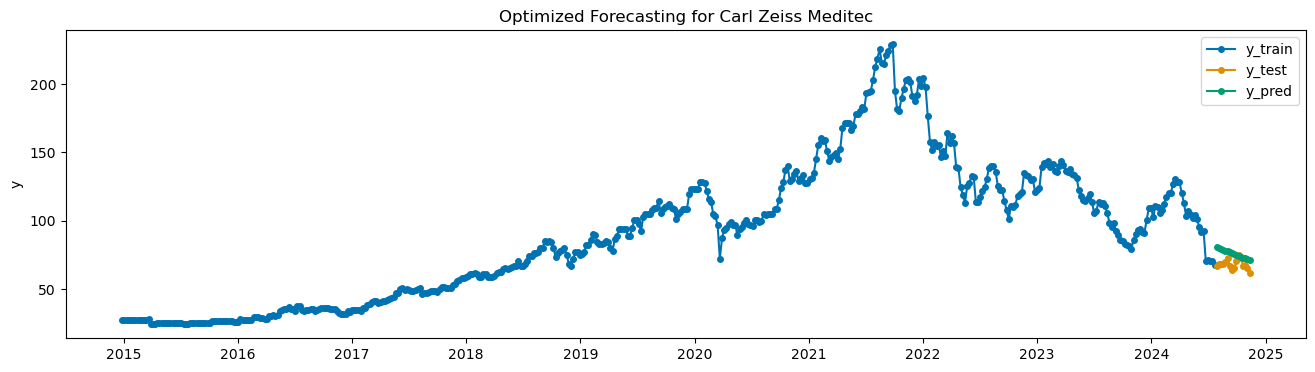

19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] done processing
19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1 of 256 for Lam Research Corporation...


19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2 of 256 for Lam Research Corporation...


19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3 of 256 for Lam Research Corporation...


19:33:30 - cmdstanpy - INFO - Chain [1] start processing
19:33:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 4 of 256 for Lam Research Corporation...


19:33:30 - cmdstanpy - INFO - Chain [1] start processing
19:33:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 5 of 256 for Lam Research Corporation...


19:33:30 - cmdstanpy - INFO - Chain [1] start processing
19:33:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 6 of 256 for Lam Research Corporation...


19:33:30 - cmdstanpy - INFO - Chain [1] start processing
19:33:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 7 of 256 for Lam Research Corporation...


19:33:31 - cmdstanpy - INFO - Chain [1] start processing
19:33:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 8 of 256 for Lam Research Corporation...


19:33:31 - cmdstanpy - INFO - Chain [1] start processing
19:33:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 9 of 256 for Lam Research Corporation...


19:33:31 - cmdstanpy - INFO - Chain [1] start processing
19:33:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 10 of 256 for Lam Research Corporation...


19:33:31 - cmdstanpy - INFO - Chain [1] start processing
19:33:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 11 of 256 for Lam Research Corporation...


19:33:32 - cmdstanpy - INFO - Chain [1] start processing
19:33:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 12 of 256 for Lam Research Corporation...


19:33:32 - cmdstanpy - INFO - Chain [1] start processing
19:33:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 13 of 256 for Lam Research Corporation...


19:33:32 - cmdstanpy - INFO - Chain [1] start processing
19:33:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 14 of 256 for Lam Research Corporation...


19:33:32 - cmdstanpy - INFO - Chain [1] start processing
19:33:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 15 of 256 for Lam Research Corporation...


19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 16 of 256 for Lam Research Corporation...
Processing combination 17 of 256 for Lam Research Corporation...


19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] done processing
19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 18 of 256 for Lam Research Corporation...


19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 19 of 256 for Lam Research Corporation...


19:33:34 - cmdstanpy - INFO - Chain [1] start processing
19:33:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 20 of 256 for Lam Research Corporation...


19:33:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 21 of 256 for Lam Research Corporation...


19:33:34 - cmdstanpy - INFO - Chain [1] done processing
19:33:34 - cmdstanpy - INFO - Chain [1] start processing
19:33:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 22 of 256 for Lam Research Corporation...


19:33:35 - cmdstanpy - INFO - Chain [1] start processing
19:33:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 23 of 256 for Lam Research Corporation...


19:33:35 - cmdstanpy - INFO - Chain [1] start processing
19:33:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 24 of 256 for Lam Research Corporation...


19:33:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 25 of 256 for Lam Research Corporation...


19:33:35 - cmdstanpy - INFO - Chain [1] done processing
19:33:35 - cmdstanpy - INFO - Chain [1] start processing
19:33:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 26 of 256 for Lam Research Corporation...


19:33:36 - cmdstanpy - INFO - Chain [1] start processing
19:33:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 27 of 256 for Lam Research Corporation...


19:33:36 - cmdstanpy - INFO - Chain [1] start processing
19:33:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 28 of 256 for Lam Research Corporation...


19:33:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 29 of 256 for Lam Research Corporation...


19:33:36 - cmdstanpy - INFO - Chain [1] done processing
19:33:36 - cmdstanpy - INFO - Chain [1] start processing
19:33:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 30 of 256 for Lam Research Corporation...


19:33:37 - cmdstanpy - INFO - Chain [1] start processing
19:33:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 31 of 256 for Lam Research Corporation...


19:33:37 - cmdstanpy - INFO - Chain [1] start processing
19:33:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 32 of 256 for Lam Research Corporation...


19:33:37 - cmdstanpy - INFO - Chain [1] start processing
19:33:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 33 of 256 for Lam Research Corporation...


19:33:37 - cmdstanpy - INFO - Chain [1] start processing
19:33:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 34 of 256 for Lam Research Corporation...


19:33:38 - cmdstanpy - INFO - Chain [1] start processing
19:33:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 35 of 256 for Lam Research Corporation...


19:33:38 - cmdstanpy - INFO - Chain [1] start processing
19:33:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 36 of 256 for Lam Research Corporation...
Processing combination 37 of 256 for Lam Research Corporation...


19:33:38 - cmdstanpy - INFO - Chain [1] start processing
19:33:38 - cmdstanpy - INFO - Chain [1] done processing
19:33:38 - cmdstanpy - INFO - Chain [1] start processing
19:33:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 38 of 256 for Lam Research Corporation...


19:33:39 - cmdstanpy - INFO - Chain [1] start processing
19:33:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 39 of 256 for Lam Research Corporation...


19:33:39 - cmdstanpy - INFO - Chain [1] start processing
19:33:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 40 of 256 for Lam Research Corporation...
Processing combination 41 of 256 for Lam Research Corporation...


19:33:39 - cmdstanpy - INFO - Chain [1] start processing
19:33:39 - cmdstanpy - INFO - Chain [1] done processing
19:33:39 - cmdstanpy - INFO - Chain [1] start processing
19:33:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 42 of 256 for Lam Research Corporation...
Processing combination 43 of 256 for Lam Research Corporation...


19:33:40 - cmdstanpy - INFO - Chain [1] start processing
19:33:40 - cmdstanpy - INFO - Chain [1] done processing
19:33:40 - cmdstanpy - INFO - Chain [1] start processing
19:33:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 44 of 256 for Lam Research Corporation...
Processing combination 45 of 256 for Lam Research Corporation...


19:33:40 - cmdstanpy - INFO - Chain [1] start processing
19:33:40 - cmdstanpy - INFO - Chain [1] done processing
19:33:40 - cmdstanpy - INFO - Chain [1] start processing
19:33:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 46 of 256 for Lam Research Corporation...


19:33:41 - cmdstanpy - INFO - Chain [1] start processing
19:33:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 47 of 256 for Lam Research Corporation...


19:33:41 - cmdstanpy - INFO - Chain [1] start processing
19:33:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 48 of 256 for Lam Research Corporation...


19:33:41 - cmdstanpy - INFO - Chain [1] start processing
19:33:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 49 of 256 for Lam Research Corporation...


19:33:41 - cmdstanpy - INFO - Chain [1] start processing
19:33:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 50 of 256 for Lam Research Corporation...
Processing combination 51 of 256 for Lam Research Corporation...


19:33:42 - cmdstanpy - INFO - Chain [1] start processing
19:33:42 - cmdstanpy - INFO - Chain [1] done processing
19:33:42 - cmdstanpy - INFO - Chain [1] start processing
19:33:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 52 of 256 for Lam Research Corporation...
Processing combination 53 of 256 for Lam Research Corporation...


19:33:42 - cmdstanpy - INFO - Chain [1] start processing
19:33:42 - cmdstanpy - INFO - Chain [1] done processing
19:33:42 - cmdstanpy - INFO - Chain [1] start processing
19:33:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 54 of 256 for Lam Research Corporation...


19:33:42 - cmdstanpy - INFO - Chain [1] start processing
19:33:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 55 of 256 for Lam Research Corporation...


19:33:43 - cmdstanpy - INFO - Chain [1] start processing
19:33:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 56 of 256 for Lam Research Corporation...


19:33:43 - cmdstanpy - INFO - Chain [1] start processing
19:33:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 57 of 256 for Lam Research Corporation...


19:33:43 - cmdstanpy - INFO - Chain [1] start processing
19:33:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 58 of 256 for Lam Research Corporation...


19:33:43 - cmdstanpy - INFO - Chain [1] start processing
19:33:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 59 of 256 for Lam Research Corporation...


19:33:44 - cmdstanpy - INFO - Chain [1] start processing
19:33:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 60 of 256 for Lam Research Corporation...
Processing combination 61 of 256 for Lam Research Corporation...


19:33:44 - cmdstanpy - INFO - Chain [1] start processing
19:33:44 - cmdstanpy - INFO - Chain [1] done processing
19:33:44 - cmdstanpy - INFO - Chain [1] start processing
19:33:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 62 of 256 for Lam Research Corporation...


19:33:44 - cmdstanpy - INFO - Chain [1] start processing
19:33:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 63 of 256 for Lam Research Corporation...


19:33:45 - cmdstanpy - INFO - Chain [1] start processing
19:33:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 64 of 256 for Lam Research Corporation...
Processing combination 65 of 256 for Lam Research Corporation...


19:33:45 - cmdstanpy - INFO - Chain [1] start processing
19:33:45 - cmdstanpy - INFO - Chain [1] done processing
19:33:45 - cmdstanpy - INFO - Chain [1] start processing
19:33:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 66 of 256 for Lam Research Corporation...


19:33:45 - cmdstanpy - INFO - Chain [1] start processing
19:33:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 67 of 256 for Lam Research Corporation...


19:33:46 - cmdstanpy - INFO - Chain [1] start processing
19:33:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 68 of 256 for Lam Research Corporation...


19:33:46 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 69 of 256 for Lam Research Corporation...


19:33:46 - cmdstanpy - INFO - Chain [1] done processing
19:33:46 - cmdstanpy - INFO - Chain [1] start processing
19:33:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 70 of 256 for Lam Research Corporation...


19:33:47 - cmdstanpy - INFO - Chain [1] start processing
19:33:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 71 of 256 for Lam Research Corporation...


19:33:47 - cmdstanpy - INFO - Chain [1] start processing
19:33:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 72 of 256 for Lam Research Corporation...


19:33:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 73 of 256 for Lam Research Corporation...


19:33:47 - cmdstanpy - INFO - Chain [1] done processing
19:33:47 - cmdstanpy - INFO - Chain [1] start processing
19:33:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 74 of 256 for Lam Research Corporation...


19:33:48 - cmdstanpy - INFO - Chain [1] start processing
19:33:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 75 of 256 for Lam Research Corporation...


19:33:48 - cmdstanpy - INFO - Chain [1] start processing
19:33:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 76 of 256 for Lam Research Corporation...


19:33:48 - cmdstanpy - INFO - Chain [1] start processing
19:33:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 77 of 256 for Lam Research Corporation...


19:33:48 - cmdstanpy - INFO - Chain [1] start processing
19:33:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 78 of 256 for Lam Research Corporation...


19:33:49 - cmdstanpy - INFO - Chain [1] start processing
19:33:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 79 of 256 for Lam Research Corporation...


19:33:49 - cmdstanpy - INFO - Chain [1] start processing
19:33:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 80 of 256 for Lam Research Corporation...


19:33:49 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 81 of 256 for Lam Research Corporation...


19:33:49 - cmdstanpy - INFO - Chain [1] done processing
19:33:49 - cmdstanpy - INFO - Chain [1] start processing
19:33:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 82 of 256 for Lam Research Corporation...


19:33:50 - cmdstanpy - INFO - Chain [1] start processing
19:33:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 83 of 256 for Lam Research Corporation...


19:33:50 - cmdstanpy - INFO - Chain [1] start processing
19:33:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 84 of 256 for Lam Research Corporation...


19:33:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 85 of 256 for Lam Research Corporation...


19:33:50 - cmdstanpy - INFO - Chain [1] done processing
19:33:50 - cmdstanpy - INFO - Chain [1] start processing
19:33:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 86 of 256 for Lam Research Corporation...


19:33:51 - cmdstanpy - INFO - Chain [1] start processing
19:33:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 87 of 256 for Lam Research Corporation...


19:33:51 - cmdstanpy - INFO - Chain [1] start processing
19:33:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 88 of 256 for Lam Research Corporation...


19:33:51 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 89 of 256 for Lam Research Corporation...


19:33:51 - cmdstanpy - INFO - Chain [1] done processing
19:33:52 - cmdstanpy - INFO - Chain [1] start processing
19:33:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 90 of 256 for Lam Research Corporation...


19:33:52 - cmdstanpy - INFO - Chain [1] start processing
19:33:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 91 of 256 for Lam Research Corporation...


19:33:52 - cmdstanpy - INFO - Chain [1] start processing
19:33:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 92 of 256 for Lam Research Corporation...


19:33:52 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 93 of 256 for Lam Research Corporation...


19:33:52 - cmdstanpy - INFO - Chain [1] done processing
19:33:53 - cmdstanpy - INFO - Chain [1] start processing
19:33:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 94 of 256 for Lam Research Corporation...


19:33:53 - cmdstanpy - INFO - Chain [1] start processing
19:33:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 95 of 256 for Lam Research Corporation...


19:33:53 - cmdstanpy - INFO - Chain [1] start processing
19:33:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 96 of 256 for Lam Research Corporation...


19:33:53 - cmdstanpy - INFO - Chain [1] start processing
19:33:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 97 of 256 for Lam Research Corporation...


19:33:54 - cmdstanpy - INFO - Chain [1] start processing
19:33:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 98 of 256 for Lam Research Corporation...


19:33:54 - cmdstanpy - INFO - Chain [1] start processing
19:33:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 99 of 256 for Lam Research Corporation...


19:33:54 - cmdstanpy - INFO - Chain [1] start processing
19:33:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 100 of 256 for Lam Research Corporation...
Processing combination 101 of 256 for Lam Research Corporation...


19:33:54 - cmdstanpy - INFO - Chain [1] start processing
19:33:54 - cmdstanpy - INFO - Chain [1] done processing
19:33:55 - cmdstanpy - INFO - Chain [1] start processing
19:33:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 102 of 256 for Lam Research Corporation...


19:33:55 - cmdstanpy - INFO - Chain [1] start processing
19:33:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 103 of 256 for Lam Research Corporation...


19:33:55 - cmdstanpy - INFO - Chain [1] start processing
19:33:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 104 of 256 for Lam Research Corporation...
Processing combination 105 of 256 for Lam Research Corporation...


19:33:55 - cmdstanpy - INFO - Chain [1] start processing
19:33:55 - cmdstanpy - INFO - Chain [1] done processing
19:33:56 - cmdstanpy - INFO - Chain [1] start processing
19:33:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 106 of 256 for Lam Research Corporation...


19:33:56 - cmdstanpy - INFO - Chain [1] start processing
19:33:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 107 of 256 for Lam Research Corporation...


19:33:56 - cmdstanpy - INFO - Chain [1] start processing
19:33:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 108 of 256 for Lam Research Corporation...
Processing combination 109 of 256 for Lam Research Corporation...


19:33:56 - cmdstanpy - INFO - Chain [1] start processing
19:33:56 - cmdstanpy - INFO - Chain [1] done processing
19:33:57 - cmdstanpy - INFO - Chain [1] start processing
19:33:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 110 of 256 for Lam Research Corporation...


19:33:57 - cmdstanpy - INFO - Chain [1] start processing
19:33:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 111 of 256 for Lam Research Corporation...


19:33:57 - cmdstanpy - INFO - Chain [1] start processing
19:33:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 112 of 256 for Lam Research Corporation...
Processing combination 113 of 256 for Lam Research Corporation...


19:33:57 - cmdstanpy - INFO - Chain [1] start processing
19:33:57 - cmdstanpy - INFO - Chain [1] done processing
19:33:58 - cmdstanpy - INFO - Chain [1] start processing
19:33:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 114 of 256 for Lam Research Corporation...


19:33:58 - cmdstanpy - INFO - Chain [1] start processing
19:33:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 115 of 256 for Lam Research Corporation...


19:33:58 - cmdstanpy - INFO - Chain [1] start processing
19:33:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 116 of 256 for Lam Research Corporation...
Processing combination 117 of 256 for Lam Research Corporation...


19:33:58 - cmdstanpy - INFO - Chain [1] start processing
19:33:58 - cmdstanpy - INFO - Chain [1] done processing
19:33:59 - cmdstanpy - INFO - Chain [1] start processing
19:33:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 118 of 256 for Lam Research Corporation...


19:33:59 - cmdstanpy - INFO - Chain [1] start processing
19:33:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 119 of 256 for Lam Research Corporation...


19:33:59 - cmdstanpy - INFO - Chain [1] start processing
19:33:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 120 of 256 for Lam Research Corporation...
Processing combination 121 of 256 for Lam Research Corporation...


19:33:59 - cmdstanpy - INFO - Chain [1] start processing
19:33:59 - cmdstanpy - INFO - Chain [1] done processing
19:33:59 - cmdstanpy - INFO - Chain [1] start processing
19:34:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 122 of 256 for Lam Research Corporation...


19:34:00 - cmdstanpy - INFO - Chain [1] start processing
19:34:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 123 of 256 for Lam Research Corporation...


19:34:00 - cmdstanpy - INFO - Chain [1] start processing
19:34:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 124 of 256 for Lam Research Corporation...
Processing combination 125 of 256 for Lam Research Corporation...


19:34:00 - cmdstanpy - INFO - Chain [1] start processing
19:34:00 - cmdstanpy - INFO - Chain [1] done processing
19:34:00 - cmdstanpy - INFO - Chain [1] start processing
19:34:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 126 of 256 for Lam Research Corporation...


19:34:01 - cmdstanpy - INFO - Chain [1] start processing
19:34:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 127 of 256 for Lam Research Corporation...


19:34:01 - cmdstanpy - INFO - Chain [1] start processing
19:34:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 128 of 256 for Lam Research Corporation...
Processing combination 129 of 256 for Lam Research Corporation...


19:34:01 - cmdstanpy - INFO - Chain [1] start processing
19:34:01 - cmdstanpy - INFO - Chain [1] done processing
19:34:02 - cmdstanpy - INFO - Chain [1] start processing
19:34:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 130 of 256 for Lam Research Corporation...


19:34:02 - cmdstanpy - INFO - Chain [1] start processing
19:34:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 131 of 256 for Lam Research Corporation...


19:34:02 - cmdstanpy - INFO - Chain [1] start processing
19:34:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 132 of 256 for Lam Research Corporation...


19:34:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 133 of 256 for Lam Research Corporation...


19:34:02 - cmdstanpy - INFO - Chain [1] done processing
19:34:03 - cmdstanpy - INFO - Chain [1] start processing
19:34:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 134 of 256 for Lam Research Corporation...


19:34:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 135 of 256 for Lam Research Corporation...


19:34:03 - cmdstanpy - INFO - Chain [1] done processing
19:34:03 - cmdstanpy - INFO - Chain [1] start processing
19:34:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 136 of 256 for Lam Research Corporation...


19:34:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 137 of 256 for Lam Research Corporation...


19:34:04 - cmdstanpy - INFO - Chain [1] done processing
19:34:04 - cmdstanpy - INFO - Chain [1] start processing
19:34:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 138 of 256 for Lam Research Corporation...


19:34:04 - cmdstanpy - INFO - Chain [1] start processing
19:34:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 139 of 256 for Lam Research Corporation...


19:34:04 - cmdstanpy - INFO - Chain [1] start processing
19:34:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 140 of 256 for Lam Research Corporation...


19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 141 of 256 for Lam Research Corporation...


19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 142 of 256 for Lam Research Corporation...


19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 143 of 256 for Lam Research Corporation...


19:34:06 - cmdstanpy - INFO - Chain [1] start processing
19:34:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 144 of 256 for Lam Research Corporation...


19:34:06 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 145 of 256 for Lam Research Corporation...


19:34:06 - cmdstanpy - INFO - Chain [1] done processing
19:34:06 - cmdstanpy - INFO - Chain [1] start processing
19:34:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 146 of 256 for Lam Research Corporation...


19:34:06 - cmdstanpy - INFO - Chain [1] start processing
19:34:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 147 of 256 for Lam Research Corporation...


19:34:07 - cmdstanpy - INFO - Chain [1] start processing
19:34:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 148 of 256 for Lam Research Corporation...


19:34:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 149 of 256 for Lam Research Corporation...


19:34:07 - cmdstanpy - INFO - Chain [1] done processing
19:34:07 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 150 of 256 for Lam Research Corporation...


19:34:07 - cmdstanpy - INFO - Chain [1] done processing
19:34:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 151 of 256 for Lam Research Corporation...


19:34:08 - cmdstanpy - INFO - Chain [1] done processing
19:34:08 - cmdstanpy - INFO - Chain [1] start processing
19:34:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 152 of 256 for Lam Research Corporation...


19:34:08 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 153 of 256 for Lam Research Corporation...


19:34:08 - cmdstanpy - INFO - Chain [1] done processing
19:34:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 154 of 256 for Lam Research Corporation...


19:34:09 - cmdstanpy - INFO - Chain [1] done processing
19:34:09 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 155 of 256 for Lam Research Corporation...


19:34:09 - cmdstanpy - INFO - Chain [1] done processing
19:34:09 - cmdstanpy - INFO - Chain [1] start processing
19:34:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 156 of 256 for Lam Research Corporation...


19:34:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 157 of 256 for Lam Research Corporation...


19:34:10 - cmdstanpy - INFO - Chain [1] done processing
19:34:10 - cmdstanpy - INFO - Chain [1] start processing
19:34:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 158 of 256 for Lam Research Corporation...


19:34:10 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 159 of 256 for Lam Research Corporation...


19:34:10 - cmdstanpy - INFO - Chain [1] done processing
19:34:11 - cmdstanpy - INFO - Chain [1] start processing
19:34:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 160 of 256 for Lam Research Corporation...


19:34:11 - cmdstanpy - INFO - Chain [1] start processing
19:34:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 161 of 256 for Lam Research Corporation...


19:34:11 - cmdstanpy - INFO - Chain [1] start processing
19:34:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 162 of 256 for Lam Research Corporation...


19:34:11 - cmdstanpy - INFO - Chain [1] start processing
19:34:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 163 of 256 for Lam Research Corporation...


19:34:12 - cmdstanpy - INFO - Chain [1] start processing
19:34:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 164 of 256 for Lam Research Corporation...


19:34:12 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 165 of 256 for Lam Research Corporation...


19:34:12 - cmdstanpy - INFO - Chain [1] done processing
19:34:12 - cmdstanpy - INFO - Chain [1] start processing
19:34:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 166 of 256 for Lam Research Corporation...


19:34:13 - cmdstanpy - INFO - Chain [1] start processing
19:34:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 167 of 256 for Lam Research Corporation...


19:34:13 - cmdstanpy - INFO - Chain [1] start processing
19:34:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 168 of 256 for Lam Research Corporation...


19:34:13 - cmdstanpy - INFO - Chain [1] start processing
19:34:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 169 of 256 for Lam Research Corporation...


19:34:13 - cmdstanpy - INFO - Chain [1] start processing
19:34:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 170 of 256 for Lam Research Corporation...


19:34:14 - cmdstanpy - INFO - Chain [1] start processing
19:34:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 171 of 256 for Lam Research Corporation...


19:34:14 - cmdstanpy - INFO - Chain [1] start processing
19:34:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 172 of 256 for Lam Research Corporation...


19:34:14 - cmdstanpy - INFO - Chain [1] start processing
19:34:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 173 of 256 for Lam Research Corporation...


19:34:14 - cmdstanpy - INFO - Chain [1] start processing
19:34:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 174 of 256 for Lam Research Corporation...


19:34:15 - cmdstanpy - INFO - Chain [1] start processing
19:34:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 175 of 256 for Lam Research Corporation...


19:34:15 - cmdstanpy - INFO - Chain [1] start processing
19:34:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 176 of 256 for Lam Research Corporation...


19:34:15 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 177 of 256 for Lam Research Corporation...


19:34:15 - cmdstanpy - INFO - Chain [1] done processing
19:34:15 - cmdstanpy - INFO - Chain [1] start processing
19:34:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 178 of 256 for Lam Research Corporation...


19:34:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 179 of 256 for Lam Research Corporation...


19:34:16 - cmdstanpy - INFO - Chain [1] done processing
19:34:16 - cmdstanpy - INFO - Chain [1] start processing
19:34:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 180 of 256 for Lam Research Corporation...


19:34:16 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 181 of 256 for Lam Research Corporation...


19:34:16 - cmdstanpy - INFO - Chain [1] done processing
19:34:17 - cmdstanpy - INFO - Chain [1] start processing
19:34:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 182 of 256 for Lam Research Corporation...


19:34:17 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 183 of 256 for Lam Research Corporation...


19:34:17 - cmdstanpy - INFO - Chain [1] done processing
19:34:17 - cmdstanpy - INFO - Chain [1] start processing
19:34:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 184 of 256 for Lam Research Corporation...


19:34:18 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 185 of 256 for Lam Research Corporation...


19:34:18 - cmdstanpy - INFO - Chain [1] done processing
19:34:18 - cmdstanpy - INFO - Chain [1] start processing
19:34:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 186 of 256 for Lam Research Corporation...


19:34:18 - cmdstanpy - INFO - Chain [1] start processing
19:34:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 187 of 256 for Lam Research Corporation...


19:34:18 - cmdstanpy - INFO - Chain [1] start processing
19:34:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 188 of 256 for Lam Research Corporation...


19:34:19 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 189 of 256 for Lam Research Corporation...


19:34:19 - cmdstanpy - INFO - Chain [1] done processing
19:34:19 - cmdstanpy - INFO - Chain [1] start processing
19:34:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 190 of 256 for Lam Research Corporation...


19:34:19 - cmdstanpy - INFO - Chain [1] start processing
19:34:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 191 of 256 for Lam Research Corporation...


19:34:19 - cmdstanpy - INFO - Chain [1] start processing
19:34:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 192 of 256 for Lam Research Corporation...


19:34:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 193 of 256 for Lam Research Corporation...


19:34:20 - cmdstanpy - INFO - Chain [1] done processing
19:34:20 - cmdstanpy - INFO - Chain [1] start processing
19:34:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 194 of 256 for Lam Research Corporation...


19:34:20 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 195 of 256 for Lam Research Corporation...


19:34:20 - cmdstanpy - INFO - Chain [1] done processing
19:34:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 196 of 256 for Lam Research Corporation...


19:34:21 - cmdstanpy - INFO - Chain [1] done processing
19:34:21 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 197 of 256 for Lam Research Corporation...


19:34:21 - cmdstanpy - INFO - Chain [1] done processing
19:34:21 - cmdstanpy - INFO - Chain [1] start processing
19:34:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 198 of 256 for Lam Research Corporation...


19:34:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 199 of 256 for Lam Research Corporation...


19:34:22 - cmdstanpy - INFO - Chain [1] done processing
19:34:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 200 of 256 for Lam Research Corporation...


19:34:22 - cmdstanpy - INFO - Chain [1] done processing
19:34:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 201 of 256 for Lam Research Corporation...


19:34:22 - cmdstanpy - INFO - Chain [1] done processing
19:34:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 202 of 256 for Lam Research Corporation...


19:34:23 - cmdstanpy - INFO - Chain [1] done processing
19:34:23 - cmdstanpy - INFO - Chain [1] start processing
19:34:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 203 of 256 for Lam Research Corporation...


19:34:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 204 of 256 for Lam Research Corporation...


19:34:23 - cmdstanpy - INFO - Chain [1] done processing
19:34:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 205 of 256 for Lam Research Corporation...


19:34:24 - cmdstanpy - INFO - Chain [1] done processing
19:34:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 206 of 256 for Lam Research Corporation...


19:34:24 - cmdstanpy - INFO - Chain [1] done processing
19:34:24 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 207 of 256 for Lam Research Corporation...


19:34:24 - cmdstanpy - INFO - Chain [1] done processing
19:34:25 - cmdstanpy - INFO - Chain [1] start processing
19:34:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 208 of 256 for Lam Research Corporation...


19:34:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 209 of 256 for Lam Research Corporation...


19:34:25 - cmdstanpy - INFO - Chain [1] done processing
19:34:25 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 210 of 256 for Lam Research Corporation...


19:34:25 - cmdstanpy - INFO - Chain [1] done processing
19:34:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 211 of 256 for Lam Research Corporation...


19:34:26 - cmdstanpy - INFO - Chain [1] done processing
19:34:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 212 of 256 for Lam Research Corporation...


19:34:26 - cmdstanpy - INFO - Chain [1] done processing
19:34:26 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 213 of 256 for Lam Research Corporation...


19:34:27 - cmdstanpy - INFO - Chain [1] done processing
19:34:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 214 of 256 for Lam Research Corporation...


19:34:27 - cmdstanpy - INFO - Chain [1] done processing
19:34:27 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 215 of 256 for Lam Research Corporation...


19:34:27 - cmdstanpy - INFO - Chain [1] done processing
19:34:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 216 of 256 for Lam Research Corporation...


19:34:28 - cmdstanpy - INFO - Chain [1] done processing
19:34:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 217 of 256 for Lam Research Corporation...


19:34:28 - cmdstanpy - INFO - Chain [1] done processing
19:34:28 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 218 of 256 for Lam Research Corporation...


19:34:29 - cmdstanpy - INFO - Chain [1] done processing
19:34:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 219 of 256 for Lam Research Corporation...


19:34:29 - cmdstanpy - INFO - Chain [1] done processing
19:34:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 220 of 256 for Lam Research Corporation...


19:34:29 - cmdstanpy - INFO - Chain [1] done processing
19:34:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 221 of 256 for Lam Research Corporation...


19:34:30 - cmdstanpy - INFO - Chain [1] done processing
19:34:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 222 of 256 for Lam Research Corporation...


19:34:30 - cmdstanpy - INFO - Chain [1] done processing
19:34:30 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 223 of 256 for Lam Research Corporation...


19:34:31 - cmdstanpy - INFO - Chain [1] done processing
19:34:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 224 of 256 for Lam Research Corporation...


19:34:31 - cmdstanpy - INFO - Chain [1] done processing
19:34:31 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 225 of 256 for Lam Research Corporation...


19:34:31 - cmdstanpy - INFO - Chain [1] done processing
19:34:31 - cmdstanpy - INFO - Chain [1] start processing
19:34:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 226 of 256 for Lam Research Corporation...


19:34:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 227 of 256 for Lam Research Corporation...


19:34:32 - cmdstanpy - INFO - Chain [1] done processing
19:34:32 - cmdstanpy - INFO - Chain [1] start processing
19:34:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 228 of 256 for Lam Research Corporation...


19:34:32 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 229 of 256 for Lam Research Corporation...


19:34:32 - cmdstanpy - INFO - Chain [1] done processing
19:34:33 - cmdstanpy - INFO - Chain [1] start processing
19:34:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 230 of 256 for Lam Research Corporation...


19:34:33 - cmdstanpy - INFO - Chain [1] start processing
19:34:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 231 of 256 for Lam Research Corporation...


19:34:33 - cmdstanpy - INFO - Chain [1] start processing
19:34:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 232 of 256 for Lam Research Corporation...


19:34:34 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 233 of 256 for Lam Research Corporation...


19:34:34 - cmdstanpy - INFO - Chain [1] done processing
19:34:34 - cmdstanpy - INFO - Chain [1] start processing
19:34:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 234 of 256 for Lam Research Corporation...


19:34:34 - cmdstanpy - INFO - Chain [1] start processing
19:34:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 235 of 256 for Lam Research Corporation...


19:34:34 - cmdstanpy - INFO - Chain [1] start processing
19:34:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 236 of 256 for Lam Research Corporation...


19:34:35 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 237 of 256 for Lam Research Corporation...


19:34:35 - cmdstanpy - INFO - Chain [1] done processing
19:34:35 - cmdstanpy - INFO - Chain [1] start processing
19:34:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 238 of 256 for Lam Research Corporation...


19:34:35 - cmdstanpy - INFO - Chain [1] start processing
19:34:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 239 of 256 for Lam Research Corporation...


19:34:36 - cmdstanpy - INFO - Chain [1] start processing
19:34:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 240 of 256 for Lam Research Corporation...


19:34:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 241 of 256 for Lam Research Corporation...


19:34:36 - cmdstanpy - INFO - Chain [1] done processing
19:34:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 242 of 256 for Lam Research Corporation...


19:34:36 - cmdstanpy - INFO - Chain [1] done processing
19:34:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 243 of 256 for Lam Research Corporation...


19:34:37 - cmdstanpy - INFO - Chain [1] done processing
19:34:37 - cmdstanpy - INFO - Chain [1] start processing
19:34:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 244 of 256 for Lam Research Corporation...


19:34:37 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 245 of 256 for Lam Research Corporation...


19:34:37 - cmdstanpy - INFO - Chain [1] done processing
19:34:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 246 of 256 for Lam Research Corporation...


19:34:38 - cmdstanpy - INFO - Chain [1] done processing
19:34:38 - cmdstanpy - INFO - Chain [1] start processing
19:34:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 247 of 256 for Lam Research Corporation...


19:34:38 - cmdstanpy - INFO - Chain [1] start processing
19:34:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 248 of 256 for Lam Research Corporation...


19:34:39 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 249 of 256 for Lam Research Corporation...


19:34:39 - cmdstanpy - INFO - Chain [1] done processing
19:34:39 - cmdstanpy - INFO - Chain [1] start processing
19:34:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 250 of 256 for Lam Research Corporation...


19:34:39 - cmdstanpy - INFO - Chain [1] start processing
19:34:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 251 of 256 for Lam Research Corporation...


19:34:39 - cmdstanpy - INFO - Chain [1] start processing
19:34:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 252 of 256 for Lam Research Corporation...


19:34:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 253 of 256 for Lam Research Corporation...


19:34:40 - cmdstanpy - INFO - Chain [1] done processing
19:34:40 - cmdstanpy - INFO - Chain [1] start processing
19:34:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 254 of 256 for Lam Research Corporation...


19:34:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 255 of 256 for Lam Research Corporation...


19:34:40 - cmdstanpy - INFO - Chain [1] done processing
19:34:41 - cmdstanpy - INFO - Chain [1] start processing
19:34:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 256 of 256 for Lam Research Corporation...
Best parameters for Lam Research Corporation: {'changepoint_prior_scale': 0.05, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05, 'weekly_seasonality': False, 'yearly_seasonality': True} with MAPE: 3.94


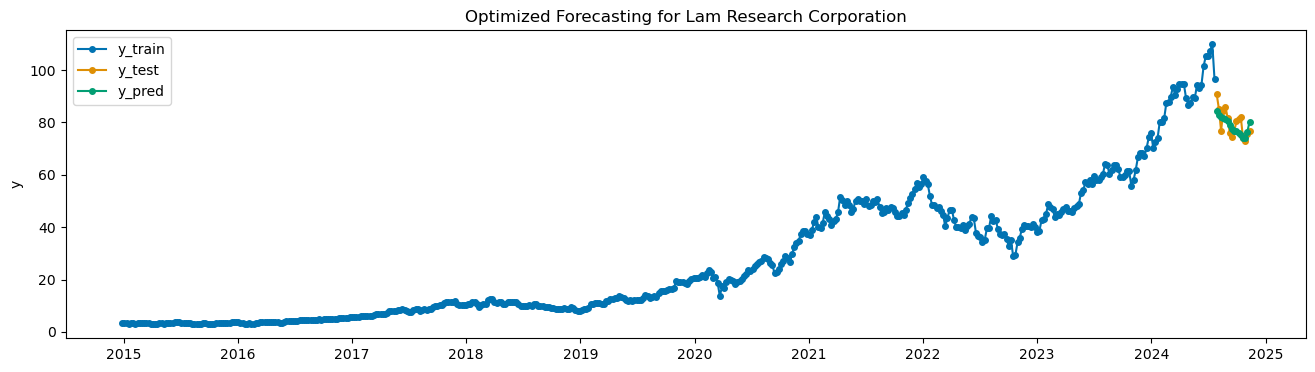

19:34:41 - cmdstanpy - INFO - Chain [1] start processing
19:34:41 - cmdstanpy - INFO - Chain [1] done processing
19:34:41 - cmdstanpy - INFO - Chain [1] start processing
19:34:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1 of 256 for Tokyo Electron Limited...


19:34:42 - cmdstanpy - INFO - Chain [1] start processing
19:34:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 2 of 256 for Tokyo Electron Limited...


19:34:42 - cmdstanpy - INFO - Chain [1] start processing
19:34:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 3 of 256 for Tokyo Electron Limited...


19:34:42 - cmdstanpy - INFO - Chain [1] start processing
19:34:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 4 of 256 for Tokyo Electron Limited...


19:34:42 - cmdstanpy - INFO - Chain [1] start processing
19:34:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 5 of 256 for Tokyo Electron Limited...


19:34:43 - cmdstanpy - INFO - Chain [1] start processing
19:34:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 6 of 256 for Tokyo Electron Limited...


19:34:43 - cmdstanpy - INFO - Chain [1] start processing
19:34:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 7 of 256 for Tokyo Electron Limited...


19:34:43 - cmdstanpy - INFO - Chain [1] start processing
19:34:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 8 of 256 for Tokyo Electron Limited...


19:34:43 - cmdstanpy - INFO - Chain [1] start processing
19:34:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 9 of 256 for Tokyo Electron Limited...


19:34:44 - cmdstanpy - INFO - Chain [1] start processing
19:34:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 10 of 256 for Tokyo Electron Limited...


19:34:44 - cmdstanpy - INFO - Chain [1] start processing
19:34:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 11 of 256 for Tokyo Electron Limited...


19:34:44 - cmdstanpy - INFO - Chain [1] start processing
19:34:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 12 of 256 for Tokyo Electron Limited...


19:34:45 - cmdstanpy - INFO - Chain [1] start processing
19:34:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 13 of 256 for Tokyo Electron Limited...


19:34:45 - cmdstanpy - INFO - Chain [1] start processing
19:34:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 14 of 256 for Tokyo Electron Limited...


19:34:45 - cmdstanpy - INFO - Chain [1] start processing
19:34:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 15 of 256 for Tokyo Electron Limited...


19:34:45 - cmdstanpy - INFO - Chain [1] start processing
19:34:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 16 of 256 for Tokyo Electron Limited...


19:34:46 - cmdstanpy - INFO - Chain [1] start processing
19:34:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 17 of 256 for Tokyo Electron Limited...


19:34:46 - cmdstanpy - INFO - Chain [1] start processing
19:34:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 18 of 256 for Tokyo Electron Limited...


19:34:46 - cmdstanpy - INFO - Chain [1] start processing
19:34:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 19 of 256 for Tokyo Electron Limited...


19:34:46 - cmdstanpy - INFO - Chain [1] start processing
19:34:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 20 of 256 for Tokyo Electron Limited...


19:34:47 - cmdstanpy - INFO - Chain [1] start processing
19:34:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 21 of 256 for Tokyo Electron Limited...


19:34:47 - cmdstanpy - INFO - Chain [1] start processing
19:34:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 22 of 256 for Tokyo Electron Limited...


19:34:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 23 of 256 for Tokyo Electron Limited...


19:34:47 - cmdstanpy - INFO - Chain [1] done processing
19:34:48 - cmdstanpy - INFO - Chain [1] start processing
19:34:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 24 of 256 for Tokyo Electron Limited...


19:34:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 25 of 256 for Tokyo Electron Limited...


19:34:48 - cmdstanpy - INFO - Chain [1] done processing
19:34:48 - cmdstanpy - INFO - Chain [1] start processing
19:34:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 26 of 256 for Tokyo Electron Limited...


19:34:48 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 27 of 256 for Tokyo Electron Limited...


19:34:49 - cmdstanpy - INFO - Chain [1] done processing
19:34:49 - cmdstanpy - INFO - Chain [1] start processing
19:34:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 28 of 256 for Tokyo Electron Limited...
Processing combination 29 of 256 for Tokyo Electron Limited...


19:34:49 - cmdstanpy - INFO - Chain [1] start processing
19:34:49 - cmdstanpy - INFO - Chain [1] done processing
19:34:49 - cmdstanpy - INFO - Chain [1] start processing
19:34:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 30 of 256 for Tokyo Electron Limited...


19:34:50 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 31 of 256 for Tokyo Electron Limited...


19:34:50 - cmdstanpy - INFO - Chain [1] done processing
19:34:50 - cmdstanpy - INFO - Chain [1] start processing
19:34:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 32 of 256 for Tokyo Electron Limited...


19:34:50 - cmdstanpy - INFO - Chain [1] start processing
19:34:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 33 of 256 for Tokyo Electron Limited...


19:34:50 - cmdstanpy - INFO - Chain [1] start processing
19:34:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 34 of 256 for Tokyo Electron Limited...


19:34:51 - cmdstanpy - INFO - Chain [1] start processing
19:34:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 35 of 256 for Tokyo Electron Limited...


19:34:51 - cmdstanpy - INFO - Chain [1] start processing
19:34:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 36 of 256 for Tokyo Electron Limited...


19:34:51 - cmdstanpy - INFO - Chain [1] start processing
19:34:51 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 37 of 256 for Tokyo Electron Limited...


19:34:52 - cmdstanpy - INFO - Chain [1] start processing
19:34:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 38 of 256 for Tokyo Electron Limited...


19:34:52 - cmdstanpy - INFO - Chain [1] start processing
19:34:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 39 of 256 for Tokyo Electron Limited...


19:34:52 - cmdstanpy - INFO - Chain [1] start processing
19:34:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 40 of 256 for Tokyo Electron Limited...


19:34:52 - cmdstanpy - INFO - Chain [1] start processing
19:34:52 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 41 of 256 for Tokyo Electron Limited...


19:34:53 - cmdstanpy - INFO - Chain [1] start processing
19:34:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 42 of 256 for Tokyo Electron Limited...


19:34:53 - cmdstanpy - INFO - Chain [1] start processing
19:34:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 43 of 256 for Tokyo Electron Limited...


19:34:53 - cmdstanpy - INFO - Chain [1] start processing
19:34:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 44 of 256 for Tokyo Electron Limited...


19:34:53 - cmdstanpy - INFO - Chain [1] start processing
19:34:53 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 45 of 256 for Tokyo Electron Limited...


19:34:54 - cmdstanpy - INFO - Chain [1] start processing
19:34:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 46 of 256 for Tokyo Electron Limited...


19:34:54 - cmdstanpy - INFO - Chain [1] start processing
19:34:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 47 of 256 for Tokyo Electron Limited...


19:34:54 - cmdstanpy - INFO - Chain [1] start processing
19:34:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 48 of 256 for Tokyo Electron Limited...


19:34:54 - cmdstanpy - INFO - Chain [1] start processing
19:34:54 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 49 of 256 for Tokyo Electron Limited...


19:34:55 - cmdstanpy - INFO - Chain [1] start processing
19:34:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 50 of 256 for Tokyo Electron Limited...


19:34:55 - cmdstanpy - INFO - Chain [1] start processing
19:34:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 51 of 256 for Tokyo Electron Limited...


19:34:55 - cmdstanpy - INFO - Chain [1] start processing
19:34:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 52 of 256 for Tokyo Electron Limited...


19:34:55 - cmdstanpy - INFO - Chain [1] start processing
19:34:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 53 of 256 for Tokyo Electron Limited...


19:34:56 - cmdstanpy - INFO - Chain [1] start processing
19:34:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 54 of 256 for Tokyo Electron Limited...


19:34:56 - cmdstanpy - INFO - Chain [1] start processing
19:34:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 55 of 256 for Tokyo Electron Limited...


19:34:56 - cmdstanpy - INFO - Chain [1] start processing
19:34:56 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 56 of 256 for Tokyo Electron Limited...


19:34:56 - cmdstanpy - INFO - Chain [1] start processing
19:34:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 57 of 256 for Tokyo Electron Limited...


19:34:57 - cmdstanpy - INFO - Chain [1] start processing
19:34:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 58 of 256 for Tokyo Electron Limited...


19:34:57 - cmdstanpy - INFO - Chain [1] start processing
19:34:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 59 of 256 for Tokyo Electron Limited...


19:34:57 - cmdstanpy - INFO - Chain [1] start processing
19:34:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 60 of 256 for Tokyo Electron Limited...
Processing combination 61 of 256 for Tokyo Electron Limited...


19:34:57 - cmdstanpy - INFO - Chain [1] start processing
19:34:58 - cmdstanpy - INFO - Chain [1] done processing
19:34:58 - cmdstanpy - INFO - Chain [1] start processing
19:34:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 62 of 256 for Tokyo Electron Limited...


19:34:58 - cmdstanpy - INFO - Chain [1] start processing
19:34:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 63 of 256 for Tokyo Electron Limited...


19:34:58 - cmdstanpy - INFO - Chain [1] start processing
19:34:58 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 64 of 256 for Tokyo Electron Limited...
Processing combination 65 of 256 for Tokyo Electron Limited...


19:34:58 - cmdstanpy - INFO - Chain [1] start processing
19:34:59 - cmdstanpy - INFO - Chain [1] done processing
19:34:59 - cmdstanpy - INFO - Chain [1] start processing
19:34:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 66 of 256 for Tokyo Electron Limited...


19:34:59 - cmdstanpy - INFO - Chain [1] start processing
19:34:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 67 of 256 for Tokyo Electron Limited...


19:34:59 - cmdstanpy - INFO - Chain [1] start processing
19:34:59 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 68 of 256 for Tokyo Electron Limited...


19:35:00 - cmdstanpy - INFO - Chain [1] start processing
19:35:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 69 of 256 for Tokyo Electron Limited...


19:35:00 - cmdstanpy - INFO - Chain [1] start processing
19:35:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 70 of 256 for Tokyo Electron Limited...


19:35:00 - cmdstanpy - INFO - Chain [1] start processing
19:35:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 71 of 256 for Tokyo Electron Limited...


19:35:00 - cmdstanpy - INFO - Chain [1] start processing
19:35:00 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 72 of 256 for Tokyo Electron Limited...


19:35:01 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 73 of 256 for Tokyo Electron Limited...


19:35:01 - cmdstanpy - INFO - Chain [1] done processing
19:35:01 - cmdstanpy - INFO - Chain [1] start processing
19:35:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 74 of 256 for Tokyo Electron Limited...


19:35:01 - cmdstanpy - INFO - Chain [1] start processing
19:35:01 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 75 of 256 for Tokyo Electron Limited...


19:35:02 - cmdstanpy - INFO - Chain [1] start processing
19:35:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 76 of 256 for Tokyo Electron Limited...


19:35:02 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 77 of 256 for Tokyo Electron Limited...


19:35:02 - cmdstanpy - INFO - Chain [1] done processing
19:35:02 - cmdstanpy - INFO - Chain [1] start processing
19:35:02 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 78 of 256 for Tokyo Electron Limited...


19:35:02 - cmdstanpy - INFO - Chain [1] start processing
19:35:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 79 of 256 for Tokyo Electron Limited...


19:35:03 - cmdstanpy - INFO - Chain [1] start processing
19:35:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 80 of 256 for Tokyo Electron Limited...


19:35:03 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 81 of 256 for Tokyo Electron Limited...


19:35:03 - cmdstanpy - INFO - Chain [1] done processing
19:35:03 - cmdstanpy - INFO - Chain [1] start processing
19:35:03 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 82 of 256 for Tokyo Electron Limited...


19:35:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 83 of 256 for Tokyo Electron Limited...


19:35:04 - cmdstanpy - INFO - Chain [1] done processing
19:35:04 - cmdstanpy - INFO - Chain [1] start processing
19:35:04 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 84 of 256 for Tokyo Electron Limited...


19:35:04 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 85 of 256 for Tokyo Electron Limited...


19:35:04 - cmdstanpy - INFO - Chain [1] done processing
19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 86 of 256 for Tokyo Electron Limited...


19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 87 of 256 for Tokyo Electron Limited...


19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 88 of 256 for Tokyo Electron Limited...


19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:05 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 89 of 256 for Tokyo Electron Limited...


19:35:06 - cmdstanpy - INFO - Chain [1] start processing
19:35:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 90 of 256 for Tokyo Electron Limited...


19:35:06 - cmdstanpy - INFO - Chain [1] start processing
19:35:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 91 of 256 for Tokyo Electron Limited...


19:35:06 - cmdstanpy - INFO - Chain [1] start processing
19:35:06 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 92 of 256 for Tokyo Electron Limited...


19:35:06 - cmdstanpy - INFO - Chain [1] start processing
19:35:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 93 of 256 for Tokyo Electron Limited...


19:35:07 - cmdstanpy - INFO - Chain [1] start processing
19:35:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 94 of 256 for Tokyo Electron Limited...


19:35:07 - cmdstanpy - INFO - Chain [1] start processing
19:35:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 95 of 256 for Tokyo Electron Limited...


19:35:07 - cmdstanpy - INFO - Chain [1] start processing
19:35:07 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 96 of 256 for Tokyo Electron Limited...


19:35:08 - cmdstanpy - INFO - Chain [1] start processing
19:35:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 97 of 256 for Tokyo Electron Limited...


19:35:08 - cmdstanpy - INFO - Chain [1] start processing
19:35:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 98 of 256 for Tokyo Electron Limited...
Processing combination 99 of 256 for Tokyo Electron Limited...


19:35:08 - cmdstanpy - INFO - Chain [1] start processing
19:35:08 - cmdstanpy - INFO - Chain [1] done processing
19:35:08 - cmdstanpy - INFO - Chain [1] start processing
19:35:08 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 100 of 256 for Tokyo Electron Limited...
Processing combination 101 of 256 for Tokyo Electron Limited...


19:35:08 - cmdstanpy - INFO - Chain [1] start processing
19:35:09 - cmdstanpy - INFO - Chain [1] done processing
19:35:09 - cmdstanpy - INFO - Chain [1] start processing
19:35:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 102 of 256 for Tokyo Electron Limited...


19:35:09 - cmdstanpy - INFO - Chain [1] start processing
19:35:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 103 of 256 for Tokyo Electron Limited...


19:35:09 - cmdstanpy - INFO - Chain [1] start processing
19:35:09 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 104 of 256 for Tokyo Electron Limited...
Processing combination 105 of 256 for Tokyo Electron Limited...


19:35:09 - cmdstanpy - INFO - Chain [1] start processing
19:35:09 - cmdstanpy - INFO - Chain [1] done processing
19:35:10 - cmdstanpy - INFO - Chain [1] start processing
19:35:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 106 of 256 for Tokyo Electron Limited...


19:35:10 - cmdstanpy - INFO - Chain [1] start processing
19:35:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 107 of 256 for Tokyo Electron Limited...


19:35:10 - cmdstanpy - INFO - Chain [1] start processing
19:35:10 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 108 of 256 for Tokyo Electron Limited...


19:35:10 - cmdstanpy - INFO - Chain [1] start processing
19:35:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 109 of 256 for Tokyo Electron Limited...


19:35:11 - cmdstanpy - INFO - Chain [1] start processing
19:35:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 110 of 256 for Tokyo Electron Limited...


19:35:11 - cmdstanpy - INFO - Chain [1] start processing
19:35:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 111 of 256 for Tokyo Electron Limited...


19:35:11 - cmdstanpy - INFO - Chain [1] start processing
19:35:11 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 112 of 256 for Tokyo Electron Limited...


19:35:11 - cmdstanpy - INFO - Chain [1] start processing
19:35:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 113 of 256 for Tokyo Electron Limited...


19:35:12 - cmdstanpy - INFO - Chain [1] start processing
19:35:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 114 of 256 for Tokyo Electron Limited...


19:35:12 - cmdstanpy - INFO - Chain [1] start processing
19:35:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 115 of 256 for Tokyo Electron Limited...


19:35:12 - cmdstanpy - INFO - Chain [1] start processing
19:35:12 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 116 of 256 for Tokyo Electron Limited...
Processing combination 117 of 256 for Tokyo Electron Limited...


19:35:13 - cmdstanpy - INFO - Chain [1] start processing
19:35:13 - cmdstanpy - INFO - Chain [1] done processing
19:35:13 - cmdstanpy - INFO - Chain [1] start processing
19:35:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 118 of 256 for Tokyo Electron Limited...


19:35:13 - cmdstanpy - INFO - Chain [1] start processing
19:35:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 119 of 256 for Tokyo Electron Limited...


19:35:13 - cmdstanpy - INFO - Chain [1] start processing
19:35:13 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 120 of 256 for Tokyo Electron Limited...


19:35:14 - cmdstanpy - INFO - Chain [1] start processing
19:35:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 121 of 256 for Tokyo Electron Limited...


19:35:14 - cmdstanpy - INFO - Chain [1] start processing
19:35:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 122 of 256 for Tokyo Electron Limited...


19:35:14 - cmdstanpy - INFO - Chain [1] start processing
19:35:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 123 of 256 for Tokyo Electron Limited...


19:35:14 - cmdstanpy - INFO - Chain [1] start processing
19:35:14 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 124 of 256 for Tokyo Electron Limited...


19:35:15 - cmdstanpy - INFO - Chain [1] start processing
19:35:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 125 of 256 for Tokyo Electron Limited...


19:35:15 - cmdstanpy - INFO - Chain [1] start processing
19:35:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 126 of 256 for Tokyo Electron Limited...


19:35:15 - cmdstanpy - INFO - Chain [1] start processing
19:35:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 127 of 256 for Tokyo Electron Limited...


19:35:15 - cmdstanpy - INFO - Chain [1] start processing
19:35:15 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 128 of 256 for Tokyo Electron Limited...
Processing combination 129 of 256 for Tokyo Electron Limited...


19:35:16 - cmdstanpy - INFO - Chain [1] start processing
19:35:16 - cmdstanpy - INFO - Chain [1] done processing
19:35:16 - cmdstanpy - INFO - Chain [1] start processing
19:35:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 130 of 256 for Tokyo Electron Limited...


19:35:16 - cmdstanpy - INFO - Chain [1] start processing
19:35:16 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 131 of 256 for Tokyo Electron Limited...


19:35:17 - cmdstanpy - INFO - Chain [1] start processing
19:35:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 132 of 256 for Tokyo Electron Limited...


19:35:17 - cmdstanpy - INFO - Chain [1] start processing
19:35:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 133 of 256 for Tokyo Electron Limited...


19:35:17 - cmdstanpy - INFO - Chain [1] start processing
19:35:17 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 134 of 256 for Tokyo Electron Limited...


19:35:17 - cmdstanpy - INFO - Chain [1] start processing
19:35:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 135 of 256 for Tokyo Electron Limited...


19:35:18 - cmdstanpy - INFO - Chain [1] start processing
19:35:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 136 of 256 for Tokyo Electron Limited...


19:35:18 - cmdstanpy - INFO - Chain [1] start processing
19:35:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 137 of 256 for Tokyo Electron Limited...


19:35:18 - cmdstanpy - INFO - Chain [1] start processing
19:35:18 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 138 of 256 for Tokyo Electron Limited...


19:35:19 - cmdstanpy - INFO - Chain [1] start processing
19:35:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 139 of 256 for Tokyo Electron Limited...


19:35:19 - cmdstanpy - INFO - Chain [1] start processing
19:35:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 140 of 256 for Tokyo Electron Limited...


19:35:19 - cmdstanpy - INFO - Chain [1] start processing
19:35:19 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 141 of 256 for Tokyo Electron Limited...


19:35:20 - cmdstanpy - INFO - Chain [1] start processing
19:35:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 142 of 256 for Tokyo Electron Limited...


19:35:20 - cmdstanpy - INFO - Chain [1] start processing
19:35:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 143 of 256 for Tokyo Electron Limited...


19:35:20 - cmdstanpy - INFO - Chain [1] start processing
19:35:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 144 of 256 for Tokyo Electron Limited...


19:35:20 - cmdstanpy - INFO - Chain [1] start processing
19:35:20 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 145 of 256 for Tokyo Electron Limited...


19:35:21 - cmdstanpy - INFO - Chain [1] start processing
19:35:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 146 of 256 for Tokyo Electron Limited...


19:35:21 - cmdstanpy - INFO - Chain [1] start processing
19:35:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 147 of 256 for Tokyo Electron Limited...


19:35:21 - cmdstanpy - INFO - Chain [1] start processing
19:35:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 148 of 256 for Tokyo Electron Limited...


19:35:21 - cmdstanpy - INFO - Chain [1] start processing
19:35:21 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 149 of 256 for Tokyo Electron Limited...


19:35:22 - cmdstanpy - INFO - Chain [1] start processing
19:35:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 150 of 256 for Tokyo Electron Limited...


19:35:22 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 151 of 256 for Tokyo Electron Limited...


19:35:22 - cmdstanpy - INFO - Chain [1] done processing
19:35:22 - cmdstanpy - INFO - Chain [1] start processing
19:35:22 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 152 of 256 for Tokyo Electron Limited...


19:35:23 - cmdstanpy - INFO - Chain [1] start processing
19:35:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 153 of 256 for Tokyo Electron Limited...


19:35:23 - cmdstanpy - INFO - Chain [1] start processing
19:35:23 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 154 of 256 for Tokyo Electron Limited...


19:35:23 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 155 of 256 for Tokyo Electron Limited...


19:35:23 - cmdstanpy - INFO - Chain [1] done processing
19:35:24 - cmdstanpy - INFO - Chain [1] start processing
19:35:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 156 of 256 for Tokyo Electron Limited...


19:35:24 - cmdstanpy - INFO - Chain [1] start processing
19:35:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 157 of 256 for Tokyo Electron Limited...


19:35:24 - cmdstanpy - INFO - Chain [1] start processing
19:35:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 158 of 256 for Tokyo Electron Limited...


19:35:24 - cmdstanpy - INFO - Chain [1] start processing
19:35:24 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 159 of 256 for Tokyo Electron Limited...


19:35:25 - cmdstanpy - INFO - Chain [1] start processing
19:35:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 160 of 256 for Tokyo Electron Limited...


19:35:25 - cmdstanpy - INFO - Chain [1] start processing
19:35:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 161 of 256 for Tokyo Electron Limited...


19:35:25 - cmdstanpy - INFO - Chain [1] start processing
19:35:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 162 of 256 for Tokyo Electron Limited...


19:35:25 - cmdstanpy - INFO - Chain [1] start processing
19:35:25 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 163 of 256 for Tokyo Electron Limited...


19:35:26 - cmdstanpy - INFO - Chain [1] start processing
19:35:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 164 of 256 for Tokyo Electron Limited...


19:35:26 - cmdstanpy - INFO - Chain [1] start processing
19:35:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 165 of 256 for Tokyo Electron Limited...


19:35:26 - cmdstanpy - INFO - Chain [1] start processing
19:35:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 166 of 256 for Tokyo Electron Limited...


19:35:26 - cmdstanpy - INFO - Chain [1] start processing
19:35:26 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 167 of 256 for Tokyo Electron Limited...


19:35:27 - cmdstanpy - INFO - Chain [1] start processing
19:35:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 168 of 256 for Tokyo Electron Limited...


19:35:27 - cmdstanpy - INFO - Chain [1] start processing
19:35:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 169 of 256 for Tokyo Electron Limited...


19:35:27 - cmdstanpy - INFO - Chain [1] start processing
19:35:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 170 of 256 for Tokyo Electron Limited...


19:35:27 - cmdstanpy - INFO - Chain [1] start processing
19:35:27 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 171 of 256 for Tokyo Electron Limited...


19:35:27 - cmdstanpy - INFO - Chain [1] start processing
19:35:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 172 of 256 for Tokyo Electron Limited...


19:35:28 - cmdstanpy - INFO - Chain [1] start processing
19:35:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 173 of 256 for Tokyo Electron Limited...


19:35:28 - cmdstanpy - INFO - Chain [1] start processing
19:35:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 174 of 256 for Tokyo Electron Limited...


19:35:28 - cmdstanpy - INFO - Chain [1] start processing
19:35:28 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 175 of 256 for Tokyo Electron Limited...


19:35:29 - cmdstanpy - INFO - Chain [1] start processing
19:35:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 176 of 256 for Tokyo Electron Limited...


19:35:29 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 177 of 256 for Tokyo Electron Limited...


19:35:29 - cmdstanpy - INFO - Chain [1] done processing
19:35:29 - cmdstanpy - INFO - Chain [1] start processing
19:35:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 178 of 256 for Tokyo Electron Limited...


19:35:29 - cmdstanpy - INFO - Chain [1] start processing
19:35:29 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 179 of 256 for Tokyo Electron Limited...


19:35:30 - cmdstanpy - INFO - Chain [1] start processing
19:35:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 180 of 256 for Tokyo Electron Limited...


19:35:30 - cmdstanpy - INFO - Chain [1] start processing
19:35:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 181 of 256 for Tokyo Electron Limited...


19:35:30 - cmdstanpy - INFO - Chain [1] start processing
19:35:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 182 of 256 for Tokyo Electron Limited...


19:35:30 - cmdstanpy - INFO - Chain [1] start processing
19:35:30 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 183 of 256 for Tokyo Electron Limited...


19:35:31 - cmdstanpy - INFO - Chain [1] start processing
19:35:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 184 of 256 for Tokyo Electron Limited...
Processing combination 185 of 256 for Tokyo Electron Limited...


19:35:31 - cmdstanpy - INFO - Chain [1] start processing
19:35:31 - cmdstanpy - INFO - Chain [1] done processing
19:35:31 - cmdstanpy - INFO - Chain [1] start processing
19:35:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 186 of 256 for Tokyo Electron Limited...


19:35:31 - cmdstanpy - INFO - Chain [1] start processing
19:35:31 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 187 of 256 for Tokyo Electron Limited...


19:35:32 - cmdstanpy - INFO - Chain [1] start processing
19:35:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 188 of 256 for Tokyo Electron Limited...


19:35:32 - cmdstanpy - INFO - Chain [1] start processing
19:35:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 189 of 256 for Tokyo Electron Limited...


19:35:32 - cmdstanpy - INFO - Chain [1] start processing
19:35:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 190 of 256 for Tokyo Electron Limited...


19:35:32 - cmdstanpy - INFO - Chain [1] start processing
19:35:32 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 191 of 256 for Tokyo Electron Limited...


19:35:33 - cmdstanpy - INFO - Chain [1] start processing
19:35:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 192 of 256 for Tokyo Electron Limited...


19:35:33 - cmdstanpy - INFO - Chain [1] start processing
19:35:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 193 of 256 for Tokyo Electron Limited...


19:35:33 - cmdstanpy - INFO - Chain [1] start processing
19:35:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 194 of 256 for Tokyo Electron Limited...


19:35:33 - cmdstanpy - INFO - Chain [1] start processing
19:35:33 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 195 of 256 for Tokyo Electron Limited...


19:35:34 - cmdstanpy - INFO - Chain [1] start processing
19:35:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 196 of 256 for Tokyo Electron Limited...


19:35:34 - cmdstanpy - INFO - Chain [1] start processing
19:35:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 197 of 256 for Tokyo Electron Limited...


19:35:34 - cmdstanpy - INFO - Chain [1] start processing
19:35:34 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 198 of 256 for Tokyo Electron Limited...


19:35:35 - cmdstanpy - INFO - Chain [1] start processing
19:35:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 199 of 256 for Tokyo Electron Limited...


19:35:35 - cmdstanpy - INFO - Chain [1] start processing
19:35:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 200 of 256 for Tokyo Electron Limited...


19:35:35 - cmdstanpy - INFO - Chain [1] start processing
19:35:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 201 of 256 for Tokyo Electron Limited...


19:35:35 - cmdstanpy - INFO - Chain [1] start processing
19:35:35 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 202 of 256 for Tokyo Electron Limited...


19:35:36 - cmdstanpy - INFO - Chain [1] start processing
19:35:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 203 of 256 for Tokyo Electron Limited...


19:35:36 - cmdstanpy - INFO - Chain [1] start processing
19:35:36 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 204 of 256 for Tokyo Electron Limited...


19:35:36 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 205 of 256 for Tokyo Electron Limited...


19:35:36 - cmdstanpy - INFO - Chain [1] done processing
19:35:37 - cmdstanpy - INFO - Chain [1] start processing
19:35:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 206 of 256 for Tokyo Electron Limited...


19:35:37 - cmdstanpy - INFO - Chain [1] start processing
19:35:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 207 of 256 for Tokyo Electron Limited...


19:35:37 - cmdstanpy - INFO - Chain [1] start processing
19:35:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 208 of 256 for Tokyo Electron Limited...


19:35:37 - cmdstanpy - INFO - Chain [1] start processing
19:35:37 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 209 of 256 for Tokyo Electron Limited...


19:35:38 - cmdstanpy - INFO - Chain [1] start processing
19:35:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 210 of 256 for Tokyo Electron Limited...


19:35:38 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 211 of 256 for Tokyo Electron Limited...


19:35:38 - cmdstanpy - INFO - Chain [1] done processing
19:35:38 - cmdstanpy - INFO - Chain [1] start processing
19:35:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 212 of 256 for Tokyo Electron Limited...


19:35:38 - cmdstanpy - INFO - Chain [1] start processing
19:35:38 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 213 of 256 for Tokyo Electron Limited...


19:35:39 - cmdstanpy - INFO - Chain [1] start processing
19:35:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 214 of 256 for Tokyo Electron Limited...


19:35:39 - cmdstanpy - INFO - Chain [1] start processing
19:35:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 215 of 256 for Tokyo Electron Limited...


19:35:39 - cmdstanpy - INFO - Chain [1] start processing
19:35:39 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 216 of 256 for Tokyo Electron Limited...


19:35:39 - cmdstanpy - INFO - Chain [1] start processing
19:35:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 217 of 256 for Tokyo Electron Limited...


19:35:40 - cmdstanpy - INFO - Chain [1] start processing
19:35:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 218 of 256 for Tokyo Electron Limited...


19:35:40 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 219 of 256 for Tokyo Electron Limited...


19:35:40 - cmdstanpy - INFO - Chain [1] done processing
19:35:40 - cmdstanpy - INFO - Chain [1] start processing
19:35:40 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 220 of 256 for Tokyo Electron Limited...


19:35:41 - cmdstanpy - INFO - Chain [1] start processing
19:35:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 221 of 256 for Tokyo Electron Limited...


19:35:41 - cmdstanpy - INFO - Chain [1] start processing
19:35:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 222 of 256 for Tokyo Electron Limited...


19:35:41 - cmdstanpy - INFO - Chain [1] start processing
19:35:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 223 of 256 for Tokyo Electron Limited...


19:35:41 - cmdstanpy - INFO - Chain [1] start processing
19:35:41 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 224 of 256 for Tokyo Electron Limited...


19:35:42 - cmdstanpy - INFO - Chain [1] start processing
19:35:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 225 of 256 for Tokyo Electron Limited...


19:35:42 - cmdstanpy - INFO - Chain [1] start processing
19:35:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 226 of 256 for Tokyo Electron Limited...


19:35:42 - cmdstanpy - INFO - Chain [1] start processing
19:35:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 227 of 256 for Tokyo Electron Limited...


19:35:42 - cmdstanpy - INFO - Chain [1] start processing
19:35:42 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 228 of 256 for Tokyo Electron Limited...


19:35:43 - cmdstanpy - INFO - Chain [1] start processing
19:35:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 229 of 256 for Tokyo Electron Limited...


19:35:43 - cmdstanpy - INFO - Chain [1] start processing
19:35:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 230 of 256 for Tokyo Electron Limited...


19:35:43 - cmdstanpy - INFO - Chain [1] start processing
19:35:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 231 of 256 for Tokyo Electron Limited...


19:35:43 - cmdstanpy - INFO - Chain [1] start processing
19:35:43 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 232 of 256 for Tokyo Electron Limited...


19:35:44 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 233 of 256 for Tokyo Electron Limited...


19:35:44 - cmdstanpy - INFO - Chain [1] done processing
19:35:44 - cmdstanpy - INFO - Chain [1] start processing
19:35:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 234 of 256 for Tokyo Electron Limited...


19:35:44 - cmdstanpy - INFO - Chain [1] start processing
19:35:44 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 235 of 256 for Tokyo Electron Limited...


19:35:44 - cmdstanpy - INFO - Chain [1] start processing
19:35:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 236 of 256 for Tokyo Electron Limited...


19:35:45 - cmdstanpy - INFO - Chain [1] start processing
19:35:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 237 of 256 for Tokyo Electron Limited...


19:35:45 - cmdstanpy - INFO - Chain [1] start processing
19:35:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 238 of 256 for Tokyo Electron Limited...


19:35:45 - cmdstanpy - INFO - Chain [1] start processing
19:35:45 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 239 of 256 for Tokyo Electron Limited...


19:35:46 - cmdstanpy - INFO - Chain [1] start processing
19:35:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 240 of 256 for Tokyo Electron Limited...


19:35:46 - cmdstanpy - INFO - Chain [1] start processing
19:35:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 241 of 256 for Tokyo Electron Limited...


19:35:46 - cmdstanpy - INFO - Chain [1] start processing
19:35:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 242 of 256 for Tokyo Electron Limited...


19:35:46 - cmdstanpy - INFO - Chain [1] start processing
19:35:46 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 243 of 256 for Tokyo Electron Limited...


19:35:47 - cmdstanpy - INFO - Chain [1] start processing
19:35:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 244 of 256 for Tokyo Electron Limited...


19:35:47 - cmdstanpy - INFO - Chain [1] start processing
19:35:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 245 of 256 for Tokyo Electron Limited...


19:35:47 - cmdstanpy - INFO - Chain [1] start processing
19:35:47 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 246 of 256 for Tokyo Electron Limited...


19:35:47 - cmdstanpy - INFO - Chain [1] start processing


Processing combination 247 of 256 for Tokyo Electron Limited...


19:35:47 - cmdstanpy - INFO - Chain [1] done processing
19:35:48 - cmdstanpy - INFO - Chain [1] start processing
19:35:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 248 of 256 for Tokyo Electron Limited...


19:35:48 - cmdstanpy - INFO - Chain [1] start processing
19:35:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 249 of 256 for Tokyo Electron Limited...


19:35:48 - cmdstanpy - INFO - Chain [1] start processing
19:35:48 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 250 of 256 for Tokyo Electron Limited...
Processing combination 251 of 256 for Tokyo Electron Limited...


19:35:48 - cmdstanpy - INFO - Chain [1] start processing
19:35:48 - cmdstanpy - INFO - Chain [1] done processing
19:35:49 - cmdstanpy - INFO - Chain [1] start processing
19:35:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 252 of 256 for Tokyo Electron Limited...


19:35:49 - cmdstanpy - INFO - Chain [1] start processing
19:35:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 253 of 256 for Tokyo Electron Limited...


19:35:49 - cmdstanpy - INFO - Chain [1] start processing
19:35:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 254 of 256 for Tokyo Electron Limited...


19:35:49 - cmdstanpy - INFO - Chain [1] start processing
19:35:49 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 255 of 256 for Tokyo Electron Limited...


19:35:50 - cmdstanpy - INFO - Chain [1] start processing
19:35:50 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 256 of 256 for Tokyo Electron Limited...
Best parameters for Tokyo Electron Limited: {'changepoint_prior_scale': 0.06, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.03, 'weekly_seasonality': True, 'yearly_seasonality': True} with MAPE: 6.17


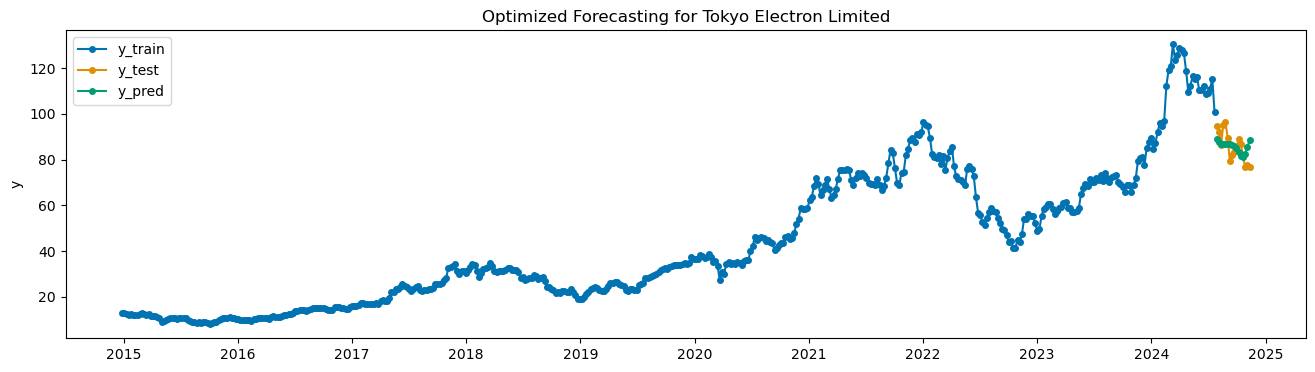

19:35:50 - cmdstanpy - INFO - Chain [1] start processing
19:35:50 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# Dictionary to store each optimized Prophet model by company
prophet_models = {}

# Hyperparameter grid for fine-tuning
param_grid = {
    'changepoint_prior_scale': [0.02, 0.03, 0.05, 0.06, 0.07],
    'seasonality_prior_scale': [0.03, 0.04, 0.05, 0.06],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False],
    'daily_seasonality': [True, False]
}

# Define the total number of parameter combinations
total_combinations = len(list(ParameterGrid(param_grid)))

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Prepare the training data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)  # Ensure DatetimeIndex
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    # Placeholder variables for tracking the best model
    best_mape = float('inf')
    best_params = None
    best_model = None

    # Perform grid search over the parameter grid
    for i, params in enumerate(ParameterGrid(param_grid), start=1):
        print(f"Processing combination {i} of {total_combinations} for {company}...")

        # Initialize and fit the Prophet model with the current set of parameters
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            seasonality_mode=params['seasonality_mode'],
            weekly_seasonality=params['weekly_seasonality'],
            yearly_seasonality=params['yearly_seasonality'],
            daily_seasonality=params['daily_seasonality']
        )
        
        # Fit the model
        model.fit(train_data_prophet)

        # Define the forecast horizon (e.g., test_weeks periods into the future)
        future = model.make_future_dataframe(periods=test_weeks, freq='W')
        forecast = model.predict(future)
        
        # Filter forecasted data
        forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]
        
        # Evaluate the model performance on test data
        actuals = test_dataframes[company]['Close']
        predictions = forecast_filtered['Close']

        # Align indices
        common_index = actuals.index.intersection(predictions.index)
        actuals = actuals.loc[common_index]
        predictions = predictions.loc[common_index]

        mape = mean_absolute_percentage_error(actuals, predictions) * 100
        rmse = root_mean_squared_error(actuals, predictions)
        
        # Check if current model is better
        if mape < best_mape:
            best_mape = mape
            best_params = params
            best_model = model

    # Print best parameters and MAPE for each company
    print(f'Best parameters for {company}: {best_params} with MAPE: {best_mape:.2f}')

    # Plot the best model's predictions
    future = best_model.make_future_dataframe(periods=test_weeks, freq='W')
    forecast = best_model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    plot_series(
        train_data_prophet.set_index('ds')[-500:],  # Only show the last 500 training points
        test_dataframes[company],                   # Test data
        forecast_filtered,                          # Forecasted data
        labels=["y_train", "y_test", "y_pred"]
    )
    
    plt.title(f'Optimized Forecasting for {company}')
    plt.show()

    # Refit the best model with all available data (train + test)
    # train_data_prophet = train_data_prophet.reset_index(names="ds")
    test_data = pd.DataFrame(actuals).rename(columns={'Close': 'y'}).reset_index(names="ds")
    all_data = pd.concat([train_data_prophet, test_data])

    # Re-initialize Prophet with the best parameters
    prophet_model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        seasonality_mode=best_params['seasonality_mode'],
        weekly_seasonality=best_params['weekly_seasonality'],
        yearly_seasonality=best_params['yearly_seasonality'],
        daily_seasonality=best_params['daily_seasonality']
    )
    
    # Fit the model on all data
    prophet_model.fit(all_data)

    # Store the optimized model in the dictionary
    prophet_models[company] = prophet_model

#### 2.5.6.4 Save the best prophet models of ASML's suppliers

In [18]:
# Iterate over each company in prophet_models
for company in company_tickers.values():
    # Define the output path for the current company's model
    output_model_path = f'models/prophet_asml_supplier_{company.replace(" ", "_")}.pkl'

    # Save the current company's Prophet model
    joblib.dump(prophet_models[company], output_model_path)
    print(f'Prophet model for {company} saved at {output_model_path}')

Prophet model for Carl Zeiss Meditec saved at models/prophet_asml_supplier_Carl_Zeiss_Meditec.pkl
Prophet model for Lam Research Corporation saved at models/prophet_asml_supplier_Lam_Research_Corporation.pkl
Prophet model for Tokyo Electron Limited saved at models/prophet_asml_supplier_Tokyo_Electron_Limited.pkl


# 3. Export the data

In [19]:
# Export the weekly_data_suppliers to a CSV file
weekly_data_suppliers.to_csv(output_data, index=True, sep=';')